<div style="background: linear-gradient(to right,rgb(225, 231, 134),rgb(176, 238, 148),rgb(150, 232, 238)); padding: 20px; border-radius: 10px; text-align: center; box-shadow: 0 10px 20px rgba(0,0,0,0.19), 0 6px 6px rgba(0,0,0,0.23);">
    <span style="font-family: 'Montserrat', sans-serif; font-weight: 800; font-size: 2.5em; color: white; text-shadow: 2px 2px 4px #000;">✨ IMPORTS ✨</span>
</div>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import precision_score, recall_score, f1_score, balanced_accuracy_score
import pickle
from collections import defaultdict
from sklearn.utils import shuffle
import os
import cv2
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import pandas as pd

from torchinfo import summary
from sklearn.metrics import confusion_matrix
import seaborn as sns

<div style="background: linear-gradient(to right,rgb(225, 231, 134),rgb(176, 238, 148),rgb(150, 232, 238)); padding: 20px; border-radius: 10px; text-align: center; box-shadow: 0 10px 20px rgba(0,0,0,0.19), 0 6px 6px rgba(0,0,0,0.23);">
    <span style="font-family: 'Montserrat', sans-serif; font-weight: 800; font-size: 2.5em; color: white; text-shadow: 2px 2px 4px #000;">✨ LOADING THE SPLIT DATA ARRAYS ✨</span>
</div>

<div style="background: linear-gradient(to right,rgb(225, 231, 134),rgb(176, 238, 148),rgb(150, 232, 238)); padding: 15px; border-radius: 8px; text-align: center; box-shadow: 0 8px 16px rgba(0,0,0,0.19), 0 4px 4px rgba(0,0,0,0.23);">
    <span style="font-family: 'Montserrat', sans-serif; font-weight: 700; font-size: 1.2em; color: white; text-shadow: 1px 1px 3px #000;">📁 reminder to change the folder path to your numpy array folder 📁</span>
</div>

In [2]:
import numpy as np
import os
from sklearn.preprocessing import StandardScaler
import cv2

# Define the folder path
folder_path = r"D:\PYTHONIG\newwindow\NOTEBOOKS_2025\aprilmay2025\data\numpy\cwtnormalized\concatenatedspectrograms"

# Load the numpy files into the respective arrays with the correct capitalized naming
eeg_fold_1 = np.load(os.path.join(folder_path, 'CWT_DATA_FOLD_fold_1.npy'))
labels_fold_1 = np.load(os.path.join(folder_path, 'CWT_LABELS_FOLD_fold_1.npy'))
patients_fold_1 = np.load(os.path.join(folder_path, 'CWT_PATIENTS_FOLD_fold_1.npy'))

eeg_fold_2 = np.load(os.path.join(folder_path, 'CWT_DATA_FOLD_fold_2.npy'))
labels_fold_2 = np.load(os.path.join(folder_path, 'CWT_LABELS_FOLD_fold_2.npy'))
patients_fold_2 = np.load(os.path.join(folder_path, 'CWT_PATIENTS_FOLD_fold_2.npy'))

eeg_fold_3 = np.load(os.path.join(folder_path, 'CWT_DATA_FOLD_fold_3.npy'))
labels_fold_3 = np.load(os.path.join(folder_path, 'CWT_LABELS_FOLD_fold_3.npy'))
patients_fold_3 = np.load(os.path.join(folder_path, 'CWT_PATIENTS_FOLD_fold_3.npy'))

eeg_fold_4 = np.load(os.path.join(folder_path, 'CWT_DATA_FOLD_fold_4.npy'))
labels_fold_4 = np.load(os.path.join(folder_path, 'CWT_LABELS_FOLD_fold_4.npy'))
patients_fold_4 = np.load(os.path.join(folder_path, 'CWT_PATIENTS_FOLD_fold_4.npy'))

eeg_fold_5 = np.load(os.path.join(folder_path, 'CWT_DATA_FOLD_fold_5.npy'))
labels_fold_5 = np.load(os.path.join(folder_path, 'CWT_LABELS_FOLD_fold_5.npy'))
patients_fold_5 = np.load(os.path.join(folder_path, 'CWT_PATIENTS_FOLD_fold_5.npy'))

eeg_folds = [eeg_fold_1, eeg_fold_2, eeg_fold_3, eeg_fold_4, eeg_fold_5]
labels_folds = [labels_fold_1, labels_fold_2, labels_fold_3, labels_fold_4, labels_fold_5]
patients_folds = [patients_fold_1, patients_fold_2, patients_fold_3, patients_fold_4, patients_fold_5]

# Add padding and resize to 224x224x3 for Vision Transformer input
for i in range(len(eeg_folds)):
    padded_images = []
    for img in eeg_folds[i]:
        padded_img = cv2.copyMakeBorder(img, 16, 16, 16, 16, cv2.BORDER_CONSTANT, value=[0, 0, 0])
        resized_img = cv2.resize(padded_img, (224, 224))
        padded_images.append(resized_img)
    eeg_folds[i] = np.array(padded_images, dtype=np.float16)

print(type(eeg_fold_4))
for i in range(len(eeg_folds)):
    eeg_folds[i] = eeg_folds[i].astype(np.float16)
    
print(eeg_folds[1].shape)

<class 'numpy.ndarray'>
(1338, 224, 224, 3)


<div style="background: linear-gradient(to right,rgb(225, 231, 134),rgb(176, 238, 148),rgb(150, 232, 238)); padding: 15px; border-radius: 8px; text-align: center; box-shadow: 0 8px 16px rgba(0,0,0,0.19), 0 4px 4px rgba(0,0,0,0.23);">
    <span style="font-family: 'Montserrat', sans-serif; font-weight: 700; font-size: 1.2em; color: white; text-shadow: 1px 1px 3px #000;">data balancer & early stopping</span>
</div>

In [3]:
def data_balancer(data, labels, factor):
    # Count the number of samples in each class
    num_class_0 = np.sum(labels == 0)
    num_class_1 = np.sum(labels == 1)
    num_class_2 = np.sum(labels == 2)

    # Find the minimum number of samples across all classes
    min_samples = min(num_class_0, num_class_1, num_class_2)

    # Calculate the number of samples to take from each class
    samples_per_class = min_samples // factor

    # Randomly sample 'samples_per_class' from each class
    class_0_indices = np.random.choice(np.where(labels == 0)[0], samples_per_class, replace=False)
    class_1_indices = np.random.choice(np.where(labels == 1)[0], samples_per_class, replace=False)
    class_2_indices = np.random.choice(np.where(labels == 2)[0], samples_per_class, replace=False)

    # Combine balanced indices
    balanced_indices = np.concatenate((class_0_indices, class_1_indices, class_2_indices))

    # Shuffle the balanced indices
    np.random.shuffle(balanced_indices)

    # Create balanced training data and labels
    balanced_data = data[balanced_indices]
    balanced_labels = labels[balanced_indices]

    return balanced_data, balanced_labels

In [4]:
class EarlyStopping:
    def __init__(self, patience=5):
        """
        Initializes the early stopping mechanism based on divergence detection.

        Args:
            patience (int): Number of consecutive epochs with increasing validation loss
                            before stopping.
        """
        self.patience = patience
        self.best_loss = None
        self.counter = 0
        self.early_stop = False
        self.best_model_state = None

    def __call__(self, val_loss, model):
        """
        Checks if the validation loss is diverging and updates the state accordingly.

        Args:
            val_loss (float): Current epoch's validation loss.
            model (torch.nn.Module): The model being trained.
        """
        if self.best_loss is None or val_loss < self.best_loss:
            # Improvement detected
            self.best_loss = val_loss
            self.best_model_state = model.state_dict()
            self.counter = 0
        else:
            # Validation loss increased
            self.counter += 1
            if self.counter >= self.patience:
                print(f"Divergence detected. Stopping training after {self.counter} epochs.")
                self.early_stop = True

    def load_best_model(self, model):
        """
        Restores the model to the state with the lowest validation loss.

        Args:
            model (torch.nn.Module): The model to restore.
        """
        model.load_state_dict(self.best_model_state)




<div style="background: linear-gradient(to right,rgb(225, 231, 134),rgb(176, 238, 148),rgb(150, 232, 238)); padding: 15px; border-radius: 8px; text-align: center; box-shadow: 0 8px 16px rgba(0,0,0,0.19), 0 4px 4px rgba(0,0,0,0.23);">
    <span style="font-family: 'Montserrat', sans-serif; font-weight: 700; font-size: 1.2em; color: white; text-shadow: 1px 1px 3px #000;">Result plotting</span>
</div>

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    precision_recall_curve,
    roc_curve,
    auc,
    f1_score,
    balanced_accuracy_score,
    classification_report,
)
from sklearn.preprocessing import label_binarize

def plot_metrics(labels, predictions, n_classes=3):
    """
    Plots and computes metrics for classification tasks.

    Args:
        labels (array-like): True labels.
        predictions (array-like): Predicted probabilities or class predictions.
        n_classes (int): Number of classes (default is 3 for multi-class classification).
    """
    # If predictions are probabilities, convert to class predictions
    if predictions.ndim > 1:
        predicted_classes = np.argmax(predictions, axis=1)
    else:
        predicted_classes = predictions

    # Confusion Matrix
    cm = confusion_matrix(labels, predicted_classes)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    # Class-wise Accuracy
    print("\nClass-wise Accuracy:")
    for d in range(n_classes):
        correct_preds = cm[d][d]
        total_true_samples = sum(cm[d])
        ratio_correct = correct_preds / total_true_samples if total_true_samples != 0 else 0
        print(f'Class {d}: Correct Predictions / Total True Samples = {correct_preds}/{total_true_samples} ({ratio_correct:.2%})')

    # Precision-Recall Curves and AUPRC
    print("\nPrecision-Recall Curves:")
    labels_binarized = label_binarize(labels, classes=np.arange(n_classes))
    auprcs = []
    for class_idx in range(n_classes):
        precision, recall, _ = precision_recall_curve(labels_binarized[:, class_idx], predictions[:, class_idx])
        auprc = auc(recall, precision)
        auprcs.append(auprc)
        plt.plot(recall, precision, label=f'Class {class_idx + 1} (AUPRC = {auprc:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves for each class')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

    # ROC Curves and AUC
    print("\nROC Curves:")
    for class_idx in range(n_classes):
        fpr, tpr, _ = roc_curve(labels_binarized[:, class_idx], predictions[:, class_idx])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {class_idx + 1} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for each class')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

    # Mean F1 Score
    f1 = f1_score(labels, predicted_classes, average='macro')
    print(f"\nMean F1 Score: {f1:.4f}")

    # Balanced Accuracy
    balanced_acc = balanced_accuracy_score(labels, predicted_classes)
    print(f"Balanced Accuracy: {balanced_acc:.4f}")

    # Average AUPRC
    mean_auprc = np.mean(auprcs)
    print(f"Average AUPRC: {mean_auprc:.4f}")

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(labels, predicted_classes))

    return {
        "confusion_matrix": cm,
        "class_wise_accuracy": [cm[d][d] / sum(cm[d]) if sum(cm[d]) != 0 else 0 for d in range(n_classes)],
        "mean_f1_score": f1,
        "balanced_accuracy": balanced_acc,
        "average_auprc": mean_auprc,
        "auprc_per_class": auprcs,
    }

<div style="background: linear-gradient(to right,rgb(225, 231, 134),rgb(238, 206, 148),rgb(238, 150, 150)); padding: 15px; border-radius: 8px; text-align: center; box-shadow: 0 8px 16px rgba(0,0,0,0.19), 0 4px 4px rgba(0,0,0,0.23);">
    <span style="font-family: 'Montserrat', sans-serif; font-weight: 700; font-size: 1.2em; color: white; text-shadow: 1px 1px 3px #000;">MODEL GOES HERE</span>
</div>

In [6]:
import torch
import torch.nn as nn

debug_mode_flag = False
# Set the device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#set random seed for reproducibility
torch.manual_seed(42)
debug_mode_flag = False


def patchify(data, n_patches):
    n, c, h, w = data.shape
    # Create tensor on the same device as input data
    patches = torch.zeros(n, n_patches**2, (c*h*w) // (n_patches**2), device=data.device)
    patch_size = h // n_patches
    for idx, d in enumerate(data):
        for i in range(n_patches):
            for j in range(n_patches):
                patch = d[:, i*patch_size: (i+1)*patch_size, j*patch_size: (j+1) * patch_size]
                patches[idx, i*n_patches + j] = patch.flatten()
    return patches

def get_positional_embeddings(sequence_length, d, device='cpu'):
    result = torch.ones(sequence_length, d, device=device)
    for i in range(sequence_length):
        for j in range(d):
            result[i][j] = np.sin(i / (10000 ** (j / d))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / d)))
    return result
class vit(nn.Module):
    def __init__(self, input_size, n_patches, hidden_size, num_classes, num_transformer_blocks=2, num_heads=4):
        super().__init__()
        self.chw = input_size
        self.n_patches = n_patches
        self.patch_size = ((self.chw[1] // n_patches) ** 2) * self.chw[0]
        
        # Core components
        self.linear_mapper = nn.Linear(self.patch_size, hidden_size)
        self.class_token = nn.Parameter(torch.rand(1, hidden_size))
        
        # Simplified positional embedding
        self.register_buffer('pos_embed', get_positional_embeddings(self.n_patches ** 2 + 1, hidden_size))
        
        # Normalization and Transformer
        self.layer_norm = nn.LayerNorm(hidden_size)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=hidden_size, nhead=num_heads, batch_first=True),
            num_layers=num_transformer_blocks
        )
        
        # Classification head
        self.classifier = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Create patches
        patches = patchify(x, self.n_patches)
        
        # Project patches to embedding dimension
        x = self.linear_mapper(patches)
        
        # Add class token
        batch_size = x.shape[0]
        cls_tokens = self.class_token.expand(batch_size, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        
        # Add positional embeddings
        x = x + self.pos_embed
        x = self.layer_norm(x)
        
        # Apply transformer
        x = self.transformer(x)
        
        # Classification based on CLS token
        x = x[:, 0]
        return self.classifier(x)

<div style="background: linear-gradient(to right,rgb(225, 231, 134),rgb(238, 206, 148),rgb(238, 150, 150)); padding: 15px; border-radius: 8px; text-align: center; box-shadow: 0 8px 16px rgba(0,0,0,0.19), 0 4px 4px rgba(0,0,0,0.23);">
    <span style="font-family: 'Montserrat', sans-serif; font-weight: 700; font-size: 1.2em; color: white; text-shadow: 1px 1px 3px #000;">Test with demo data & model Summary</span>
</div>

In [7]:

randomdata = torch.randn((1, 3, 224, 224))  # Adjusted to match the input shape (batch_size, channels, height, width)

# Modify the vit parameters to accommodate the shape mismatch
model = vit(input_size=(3, 224, 224), n_patches=14, hidden_size=256, num_classes=3)  # Adjusted n_patches and hidden_size
output = model(randomdata)
output.shape

torch.Size([1, 3])

In [8]:
from torchinfo import summary

summary(model)

Layer (type:depth-idx)                                            Param #
vit                                                               256
├─Linear: 1-1                                                     196,864
├─LayerNorm: 1-2                                                  512
├─TransformerEncoder: 1-3                                         --
│    └─ModuleList: 2-1                                            --
│    │    └─TransformerEncoderLayer: 3-1                          1,315,072
│    │    └─TransformerEncoderLayer: 3-2                          1,315,072
├─Linear: 1-4                                                     771
Total params: 2,828,547
Trainable params: 2,828,547
Non-trainable params: 0

<div style="background: linear-gradient(to right,rgb(225, 231, 134),rgb(238, 206, 148),rgb(238, 150, 150)); padding: 15px; border-radius: 8px; text-align: center; box-shadow: 0 8px 16px rgba(0,0,0,0.19), 0 4px 4px rgba(0,0,0,0.23);">
    <span style="font-family: 'Montserrat', sans-serif; font-weight: 700; font-size: 1.2em; color: white; text-shadow: 1px 1px 3px #000;">Training Code</span>
</div>

Running experiment with parameters: {'n_patches': 28, 'embed_dim': 128, 'learning_rate': 3.6467910524712975e-05, 'weight_decay': 1.1407515349694686e-05, 'batch_size': 32, 'num_transformer_blocks': 6, 'num_heads': 8, 'accuracy': 0.4555}
__________________________________________________
__________________________________________________
__________________________________________________
__________________________________________________
__________________________________________________
Fold No: 1
Epoch [1/100], Loss: 1.1112, Accuracy: 0.3475
Validation Loss: 1.0627, Validation Accuracy: 0.3199
Epoch [2/100], Loss: 1.1006, Accuracy: 0.3855
Validation Loss: 1.1243, Validation Accuracy: 0.3374
Epoch [3/100], Loss: 1.0930, Accuracy: 0.3873
Validation Loss: 1.0954, Validation Accuracy: 0.3843
Epoch [4/100], Loss: 1.0913, Accuracy: 0.3890
Validation Loss: 1.1023, Validation Accuracy: 0.3403
Epoch [5/100], Loss: 1.0821, Accuracy: 0.4288
Validation Loss: 1.1263, Validation Accuracy: 0.3432
Epo

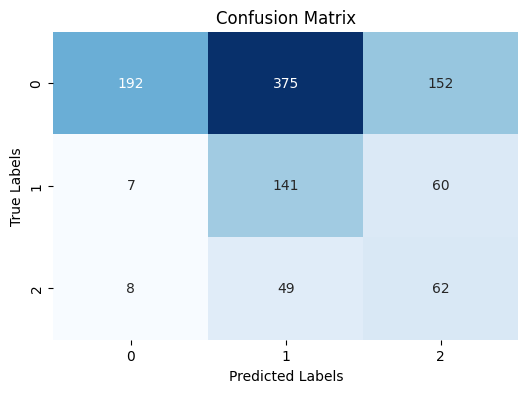


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 192/719 (26.70%)
Class 1: Correct Predictions / Total True Samples = 141/208 (67.79%)
Class 2: Correct Predictions / Total True Samples = 62/119 (52.10%)

Precision-Recall Curves:


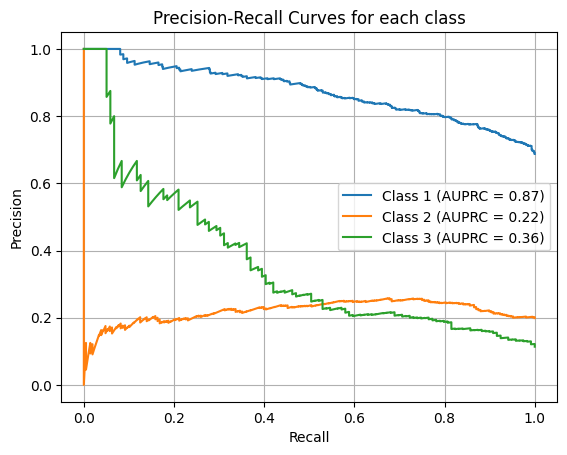


ROC Curves:


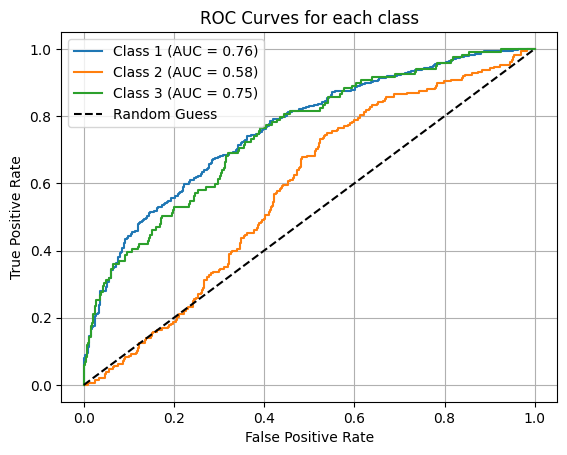


Mean F1 Score: 0.3650
Balanced Accuracy: 0.4886
Average AUPRC: 0.4825

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.27      0.41       719
           1       0.25      0.68      0.36       208
           2       0.23      0.52      0.32       119

    accuracy                           0.38      1046
   macro avg       0.47      0.49      0.37      1046
weighted avg       0.71      0.38      0.39      1046

Fold No: 2
Epoch [1/100], Loss: 1.1164, Accuracy: 0.3587
Validation Loss: 1.1007, Validation Accuracy: 0.3333
Epoch [2/100], Loss: 1.1115, Accuracy: 0.3406
Validation Loss: 1.1394, Validation Accuracy: 0.4101
Epoch [3/100], Loss: 1.1062, Accuracy: 0.3645
Validation Loss: 1.0970, Validation Accuracy: 0.4192
Epoch [4/100], Loss: 1.0960, Accuracy: 0.3848
Validation Loss: 1.0555, Validation Accuracy: 0.4377
Epoch [5/100], Loss: 1.0912, Accuracy: 0.3710
Validation Loss: 1.1084, Validation Accuracy: 0.4324
Epoch [6/100], Los

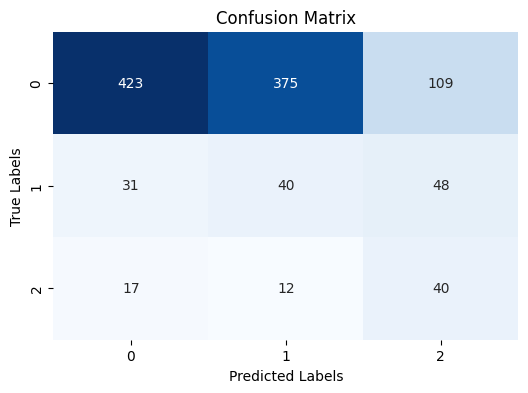


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 423/907 (46.64%)
Class 1: Correct Predictions / Total True Samples = 40/119 (33.61%)
Class 2: Correct Predictions / Total True Samples = 40/69 (57.97%)

Precision-Recall Curves:


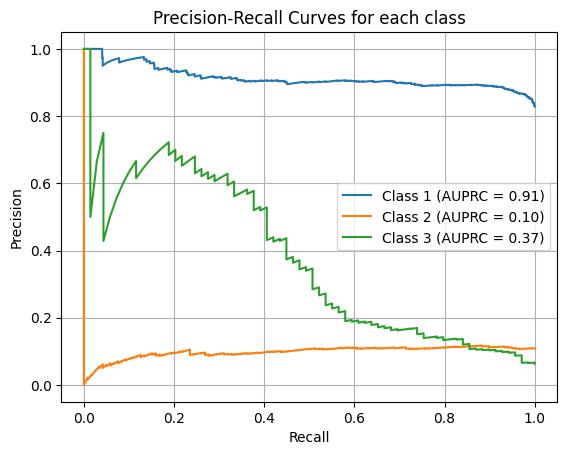


ROC Curves:


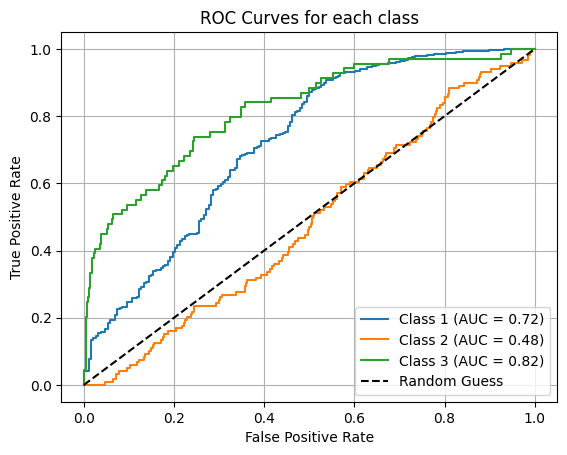


Mean F1 Score: 0.3537
Balanced Accuracy: 0.4607
Average AUPRC: 0.4610

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.47      0.61       907
           1       0.09      0.34      0.15       119
           2       0.20      0.58      0.30        69

    accuracy                           0.46      1095
   macro avg       0.40      0.46      0.35      1095
weighted avg       0.77      0.46      0.54      1095

Fold No: 3
Epoch [1/100], Loss: 1.1099, Accuracy: 0.3777
Validation Loss: 1.0917, Validation Accuracy: 0.3243
Epoch [2/100], Loss: 1.1128, Accuracy: 0.3452
Validation Loss: 1.0840, Validation Accuracy: 0.3104
Epoch [3/100], Loss: 1.1026, Accuracy: 0.3705
Validation Loss: 1.1064, Validation Accuracy: 0.3348
Epoch [4/100], Loss: 1.1020, Accuracy: 0.3603
Validation Loss: 1.1186, Validation Accuracy: 0.3410
Epoch [5/100], Loss: 1.0959, Accuracy: 0.3832
Validation Loss: 1.1178, Validation Accuracy: 0.3309
Epoch [6/100], Los

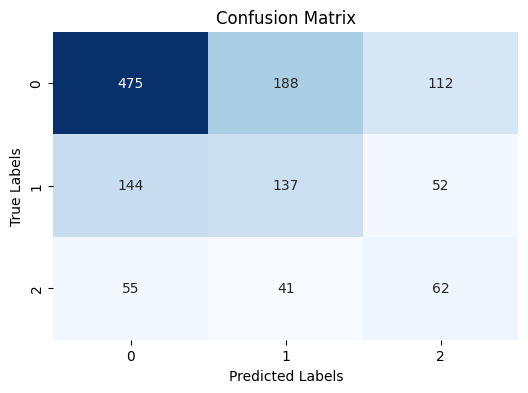


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 475/775 (61.29%)
Class 1: Correct Predictions / Total True Samples = 137/333 (41.14%)
Class 2: Correct Predictions / Total True Samples = 62/158 (39.24%)

Precision-Recall Curves:


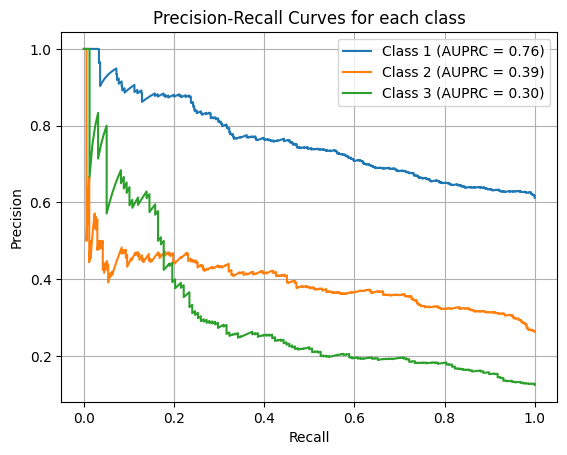


ROC Curves:


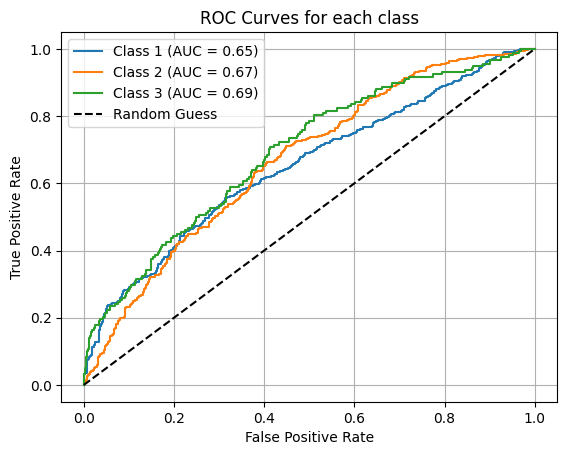


Mean F1 Score: 0.4568
Balanced Accuracy: 0.4722
Average AUPRC: 0.4824

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.61      0.66       775
           1       0.37      0.41      0.39       333
           2       0.27      0.39      0.32       158

    accuracy                           0.53      1266
   macro avg       0.45      0.47      0.46      1266
weighted avg       0.56      0.53      0.54      1266

Fold No: 4
Epoch [1/100], Loss: 1.1194, Accuracy: 0.3245
Validation Loss: 1.1340, Validation Accuracy: 0.3333
Epoch [2/100], Loss: 1.1103, Accuracy: 0.3382
Validation Loss: 1.1626, Validation Accuracy: 0.4364
Epoch [3/100], Loss: 1.1041, Accuracy: 0.3549
Validation Loss: 1.1553, Validation Accuracy: 0.3333
Epoch [4/100], Loss: 1.1041, Accuracy: 0.3412
Validation Loss: 1.1466, Validation Accuracy: 0.4403
Epoch [5/100], Loss: 1.1018, Accuracy: 0.3363
Validation Loss: 1.0491, Validation Accuracy: 0.3819
Epoch [6/100], Los

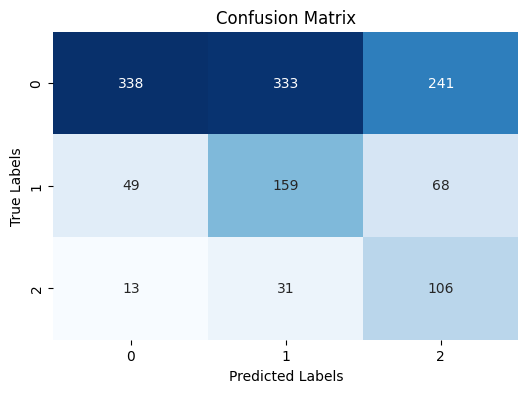


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 338/912 (37.06%)
Class 1: Correct Predictions / Total True Samples = 159/276 (57.61%)
Class 2: Correct Predictions / Total True Samples = 106/150 (70.67%)

Precision-Recall Curves:


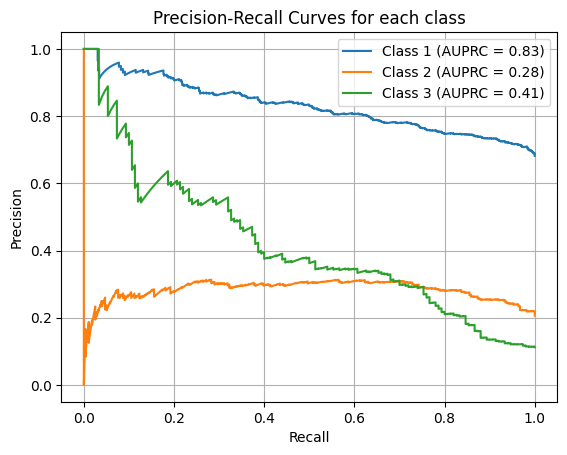


ROC Curves:


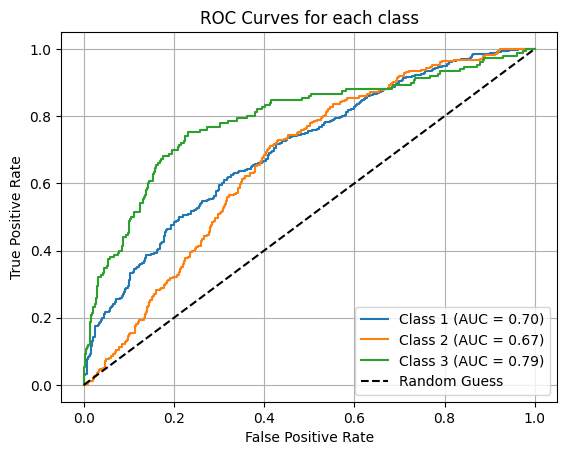


Mean F1 Score: 0.4295
Balanced Accuracy: 0.5511
Average AUPRC: 0.5085

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.37      0.52       912
           1       0.30      0.58      0.40       276
           2       0.26      0.71      0.38       150

    accuracy                           0.45      1338
   macro avg       0.47      0.55      0.43      1338
weighted avg       0.67      0.45      0.48      1338

Fold No: 5
Epoch [1/100], Loss: 1.1109, Accuracy: 0.3748
Validation Loss: 1.0937, Validation Accuracy: 0.3911
Epoch [2/100], Loss: 1.1018, Accuracy: 0.3584
Validation Loss: 1.1836, Validation Accuracy: 0.3649
Epoch [3/100], Loss: 1.1011, Accuracy: 0.3767
Validation Loss: 1.0846, Validation Accuracy: 0.4818
Epoch [4/100], Loss: 1.0925, Accuracy: 0.3979
Validation Loss: 1.0776, Validation Accuracy: 0.3819
Epoch [5/100], Loss: 1.0956, Accuracy: 0.3805
Validation Loss: 1.1584, Validation Accuracy: 0.4559
Epoch [6/100], Los

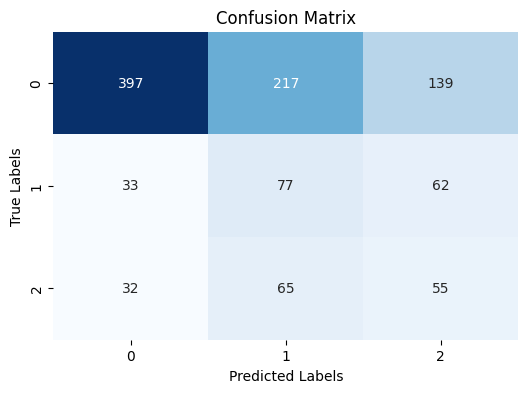


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 397/753 (52.72%)
Class 1: Correct Predictions / Total True Samples = 77/172 (44.77%)
Class 2: Correct Predictions / Total True Samples = 55/152 (36.18%)

Precision-Recall Curves:


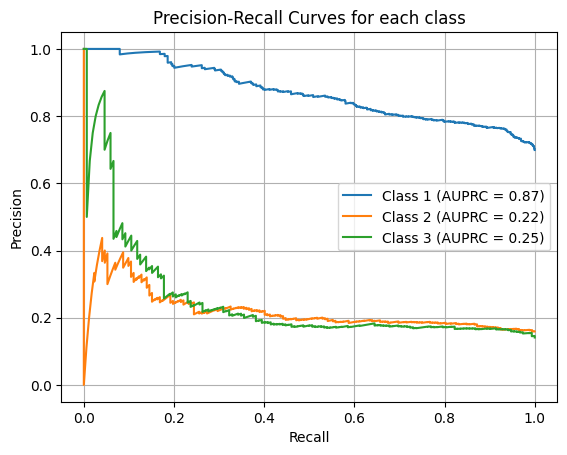


ROC Curves:


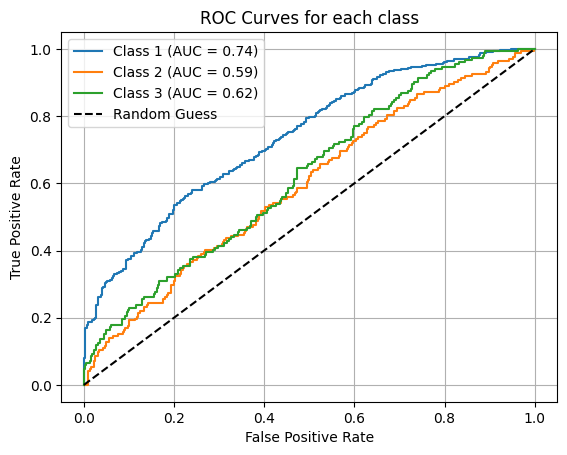


Mean F1 Score: 0.4044
Balanced Accuracy: 0.4456
Average AUPRC: 0.4448

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.53      0.65       753
           1       0.21      0.45      0.29       172
           2       0.21      0.36      0.27       152

    accuracy                           0.49      1077
   macro avg       0.43      0.45      0.40      1077
weighted avg       0.67      0.49      0.54      1077

Accuracy for each fold: [np.float64(0.4886435236339106), np.float64(0.46073908527346835), np.float64(0.4722399001696675), np.float64(0.5511225527587084), np.float64(0.44558031981959284)]
AUPRC for each fold: [np.float64(0.4825061945518668), np.float64(0.4609771301397856), np.float64(0.482401252065425), np.float64(0.5085041890639522), np.float64(0.4447823250722012)]
Average AUPRC across all folds: 0.47583421817864613
Average Balanced Accuracy across all folds: 0.48366507633106953
Results saved to D:\PYTHONIG\newwindow\N

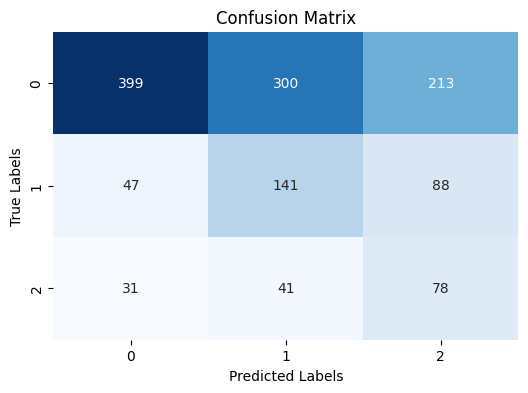


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 399/912 (43.75%)
Class 1: Correct Predictions / Total True Samples = 141/276 (51.09%)
Class 2: Correct Predictions / Total True Samples = 78/150 (52.00%)

Precision-Recall Curves:


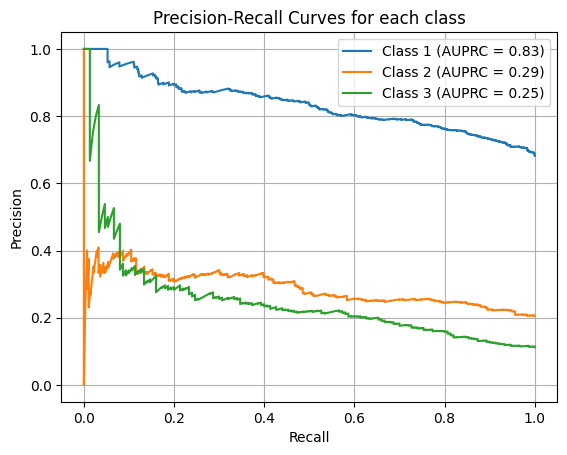


ROC Curves:


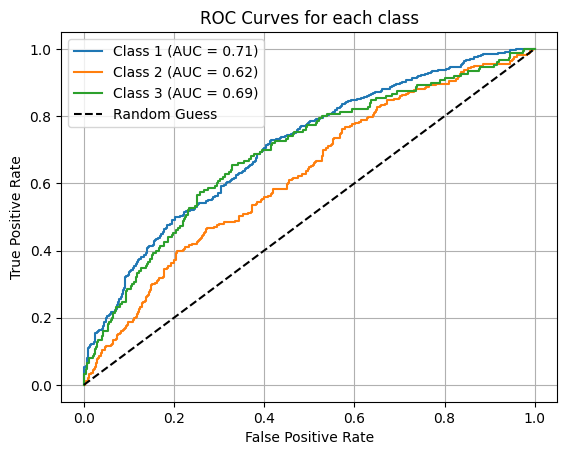


Mean F1 Score: 0.4138
Balanced Accuracy: 0.4895
Average AUPRC: 0.4559

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.44      0.57       912
           1       0.29      0.51      0.37       276
           2       0.21      0.52      0.29       150

    accuracy                           0.46      1338
   macro avg       0.44      0.49      0.41      1338
weighted avg       0.65      0.46      0.50      1338

Fold No: 2
Epoch [1/100], Loss: 1.1250, Accuracy: 0.3266
Validation Loss: 1.1935, Validation Accuracy: 0.3463
Epoch [2/100], Loss: 1.0965, Accuracy: 0.3507
Validation Loss: 1.0446, Validation Accuracy: 0.3320
Epoch [3/100], Loss: 1.1028, Accuracy: 0.3661
Validation Loss: 1.0541, Validation Accuracy: 0.3438
Epoch [4/100], Loss: 1.0943, Accuracy: 0.3748
Validation Loss: 1.1182, Validation Accuracy: 0.4376
Epoch [5/100], Loss: 1.0867, Accuracy: 0.3940
Validation Loss: 1.0554, Validation Accuracy: 0.5066
Epoch [6/100], Los

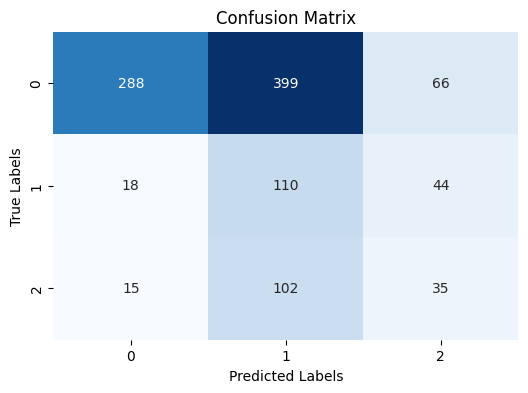


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 288/753 (38.25%)
Class 1: Correct Predictions / Total True Samples = 110/172 (63.95%)
Class 2: Correct Predictions / Total True Samples = 35/152 (23.03%)

Precision-Recall Curves:


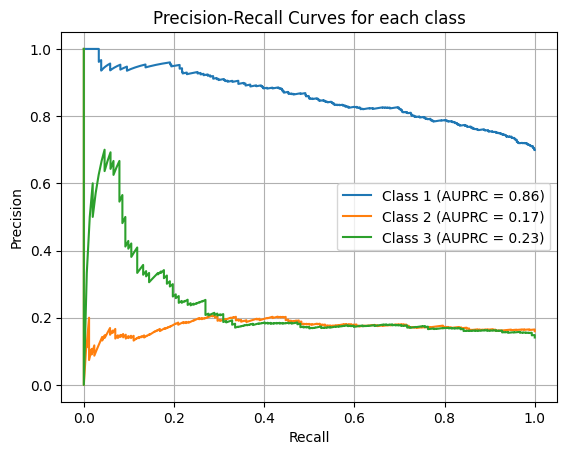


ROC Curves:


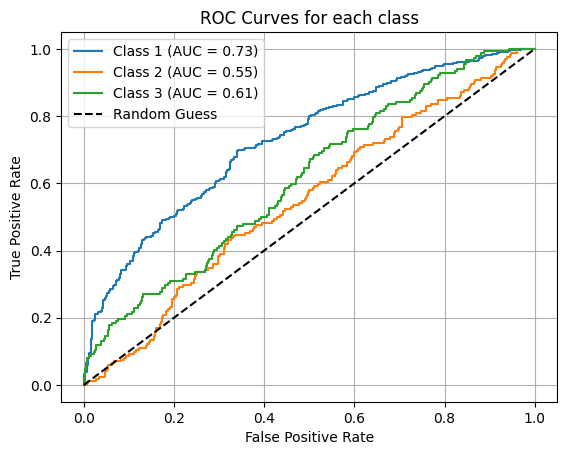


Mean F1 Score: 0.3510
Balanced Accuracy: 0.4174
Average AUPRC: 0.4214

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.38      0.54       753
           1       0.18      0.64      0.28       172
           2       0.24      0.23      0.24       152

    accuracy                           0.40      1077
   macro avg       0.44      0.42      0.35      1077
weighted avg       0.69      0.40      0.45      1077

Fold No: 3
Epoch [1/100], Loss: 1.1234, Accuracy: 0.3271
Validation Loss: 1.0819, Validation Accuracy: 0.3110
Epoch [2/100], Loss: 1.0940, Accuracy: 0.3935
Validation Loss: 1.0784, Validation Accuracy: 0.3534
Epoch [3/100], Loss: 1.0855, Accuracy: 0.4200
Validation Loss: 1.1896, Validation Accuracy: 0.3083
Epoch [4/100], Loss: 1.0839, Accuracy: 0.4164
Validation Loss: 1.2386, Validation Accuracy: 0.3237
Epoch [5/100], Loss: 1.0724, Accuracy: 0.4350
Validation Loss: 1.0768, Validation Accuracy: 0.3933
Epoch [6/100], Los

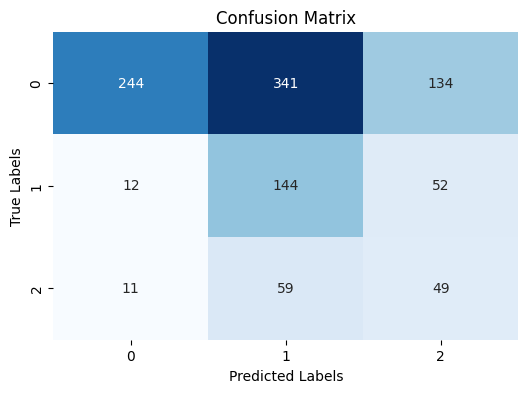


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 244/719 (33.94%)
Class 1: Correct Predictions / Total True Samples = 144/208 (69.23%)
Class 2: Correct Predictions / Total True Samples = 49/119 (41.18%)

Precision-Recall Curves:


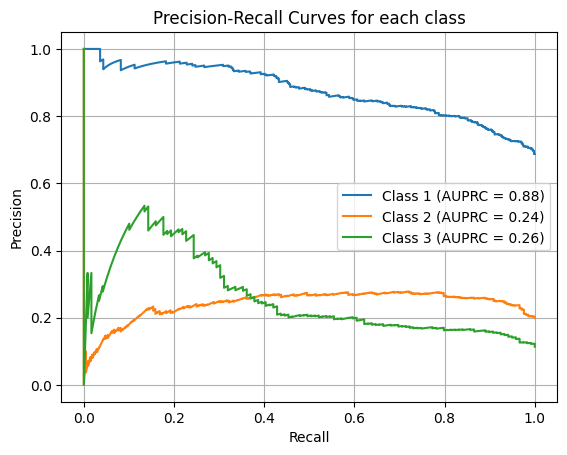


ROC Curves:


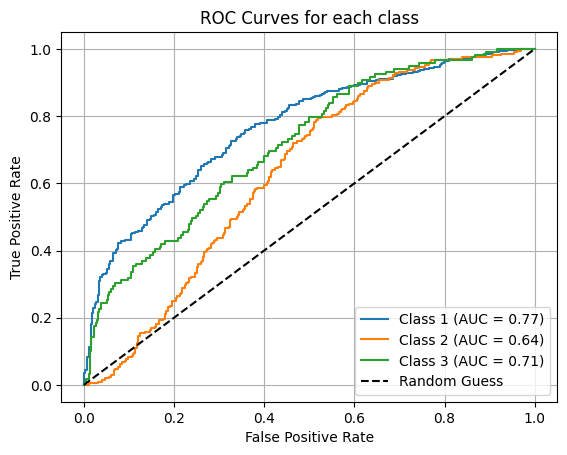


Mean F1 Score: 0.3849
Balanced Accuracy: 0.4811
Average AUPRC: 0.4575

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.34      0.49       719
           1       0.26      0.69      0.38       208
           2       0.21      0.41      0.28       119

    accuracy                           0.42      1046
   macro avg       0.46      0.48      0.38      1046
weighted avg       0.70      0.42      0.45      1046

Fold No: 4
Epoch [1/100], Loss: 1.1179, Accuracy: 0.3154
Validation Loss: 1.0615, Validation Accuracy: 0.3333
Epoch [2/100], Loss: 1.1079, Accuracy: 0.3450
Validation Loss: 1.0823, Validation Accuracy: 0.3464
Epoch [3/100], Loss: 1.0985, Accuracy: 0.3639
Validation Loss: 1.0862, Validation Accuracy: 0.4169
Epoch [4/100], Loss: 1.0941, Accuracy: 0.3792
Validation Loss: 1.0838, Validation Accuracy: 0.3573
Epoch [5/100], Loss: 1.0941, Accuracy: 0.3980
Validation Loss: 1.1312, Validation Accuracy: 0.3677
Epoch [6/100], Los

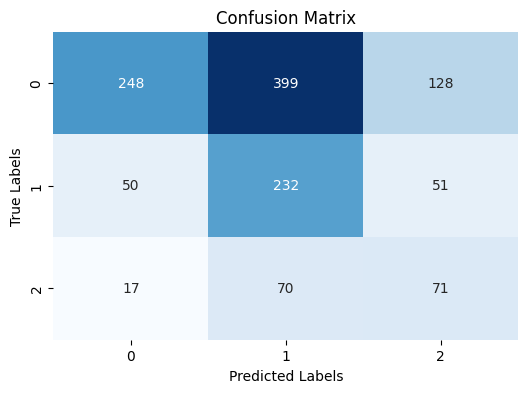


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 248/775 (32.00%)
Class 1: Correct Predictions / Total True Samples = 232/333 (69.67%)
Class 2: Correct Predictions / Total True Samples = 71/158 (44.94%)

Precision-Recall Curves:


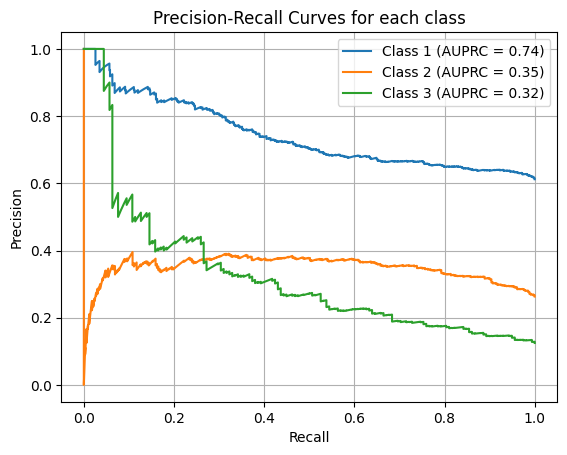


ROC Curves:


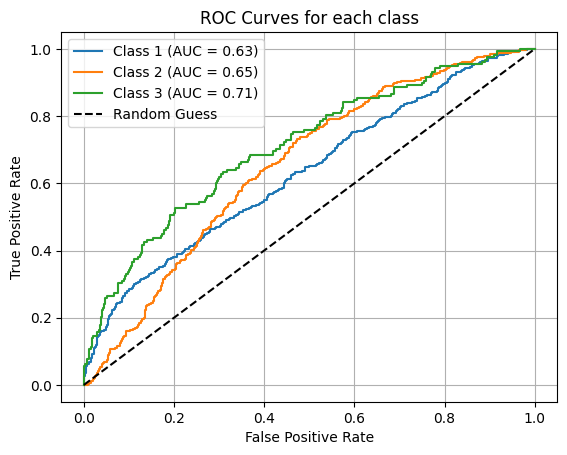


Mean F1 Score: 0.4173
Balanced Accuracy: 0.4887
Average AUPRC: 0.4699

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.32      0.46       775
           1       0.33      0.70      0.45       333
           2       0.28      0.45      0.35       158

    accuracy                           0.44      1266
   macro avg       0.47      0.49      0.42      1266
weighted avg       0.60      0.44      0.44      1266

Fold No: 5
Epoch [1/100], Loss: 1.1112, Accuracy: 0.3587
Validation Loss: 1.1094, Validation Accuracy: 0.3500
Epoch [2/100], Loss: 1.1002, Accuracy: 0.3595
Validation Loss: 1.0839, Validation Accuracy: 0.3922
Epoch [3/100], Loss: 1.0920, Accuracy: 0.3848
Validation Loss: 1.0645, Validation Accuracy: 0.4006
Epoch [4/100], Loss: 1.0956, Accuracy: 0.3785
Validation Loss: 1.1128, Validation Accuracy: 0.4252
Epoch [5/100], Loss: 1.0894, Accuracy: 0.3983
Validation Loss: 1.0857, Validation Accuracy: 0.4358
Epoch [6/100], Los

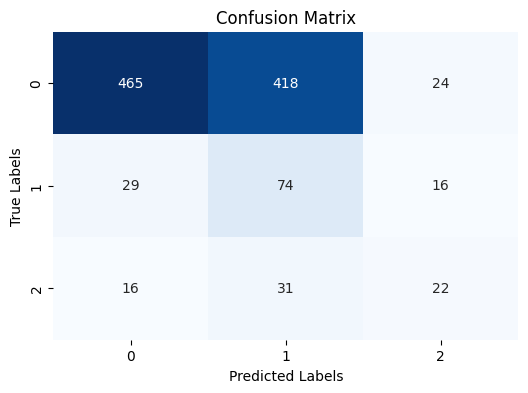


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 465/907 (51.27%)
Class 1: Correct Predictions / Total True Samples = 74/119 (62.18%)
Class 2: Correct Predictions / Total True Samples = 22/69 (31.88%)

Precision-Recall Curves:


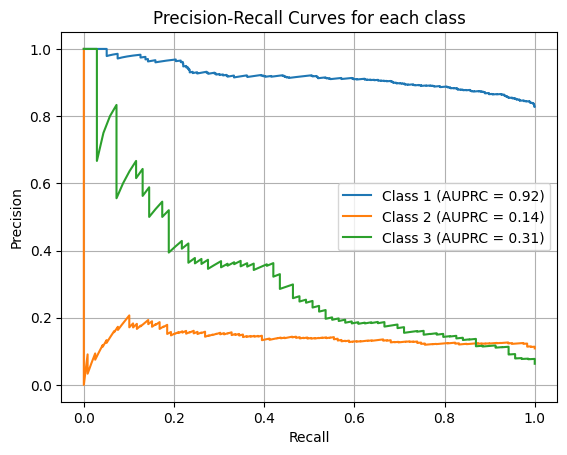


ROC Curves:


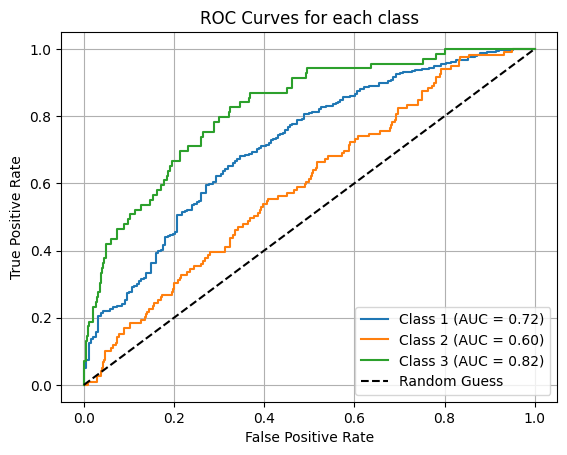


Mean F1 Score: 0.4076
Balanced Accuracy: 0.4845
Average AUPRC: 0.4566

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.51      0.66       907
           1       0.14      0.62      0.23       119
           2       0.35      0.32      0.34        69

    accuracy                           0.51      1095
   macro avg       0.47      0.48      0.41      1095
weighted avg       0.79      0.51      0.59      1095

Accuracy for each fold: [np.float64(0.48945652173913046), np.float64(0.4174227203791931), np.float64(0.48114420690711296), np.float64(0.48868792843476383), np.float64(0.4844561604262368)]
AUPRC for each fold: [np.float64(0.4558669016647961), np.float64(0.421431661060282), np.float64(0.45754708587260895), np.float64(0.4698625577736771), np.float64(0.45660731012504835)]
Average AUPRC across all folds: 0.4522631032992825
Average Balanced Accuracy across all folds: 0.47223350757728744
Results saved to D:\PYTHONIG\newwindow

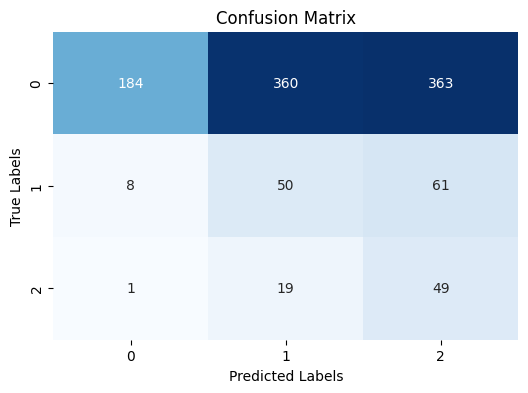


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 184/907 (20.29%)
Class 1: Correct Predictions / Total True Samples = 50/119 (42.02%)
Class 2: Correct Predictions / Total True Samples = 49/69 (71.01%)

Precision-Recall Curves:


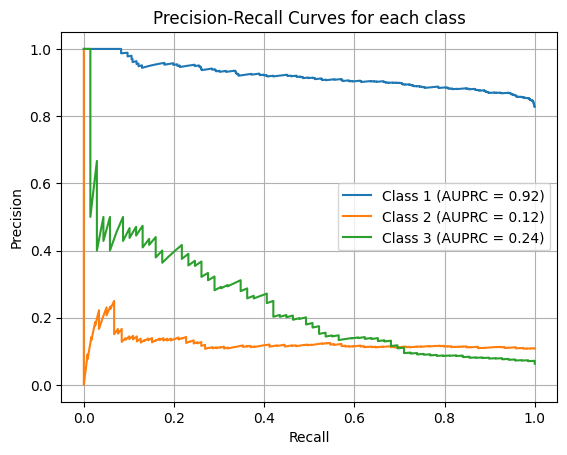


ROC Curves:


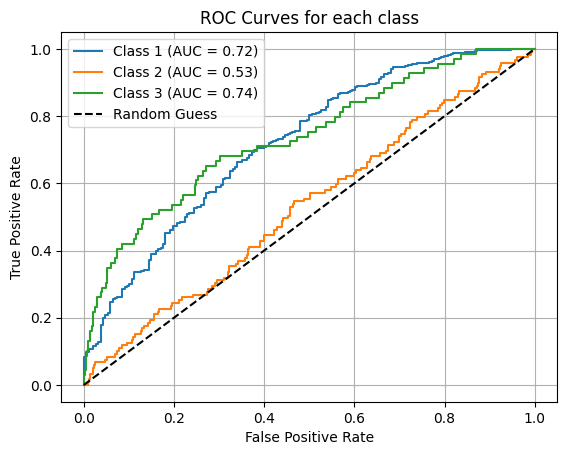


Mean F1 Score: 0.2326
Balanced Accuracy: 0.4444
Average AUPRC: 0.4254

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.20      0.33       907
           1       0.12      0.42      0.18       119
           2       0.10      0.71      0.18        69

    accuracy                           0.26      1095
   macro avg       0.39      0.44      0.23      1095
weighted avg       0.81      0.26      0.31      1095

Fold No: 2
Epoch [1/100], Loss: 1.1274, Accuracy: 0.3528
Validation Loss: 1.2113, Validation Accuracy: 0.3333
Epoch [2/100], Loss: 1.1071, Accuracy: 0.3636
Validation Loss: 1.0507, Validation Accuracy: 0.3233
Epoch [3/100], Loss: 1.0965, Accuracy: 0.4087
Validation Loss: 1.0801, Validation Accuracy: 0.3766
Epoch [4/100], Loss: 1.0924, Accuracy: 0.4079
Validation Loss: 1.0067, Validation Accuracy: 0.4285
Epoch [5/100], Loss: 1.0781, Accuracy: 0.4343
Validation Loss: 1.0260, Validation Accuracy: 0.4483
Epoch [6/100], Los

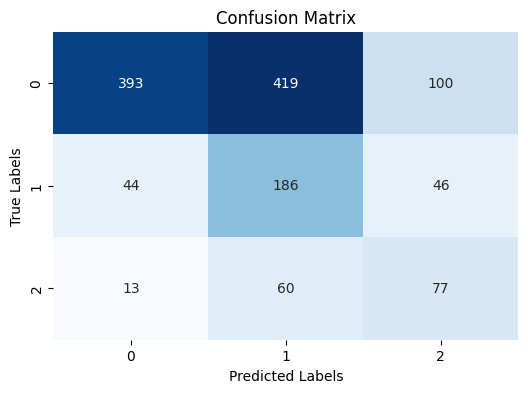


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 393/912 (43.09%)
Class 1: Correct Predictions / Total True Samples = 186/276 (67.39%)
Class 2: Correct Predictions / Total True Samples = 77/150 (51.33%)

Precision-Recall Curves:


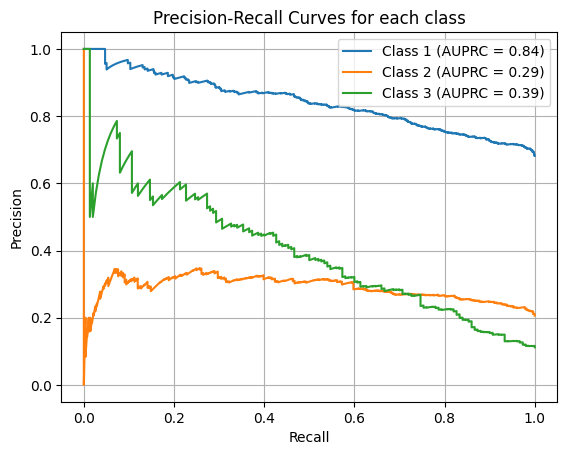


ROC Curves:


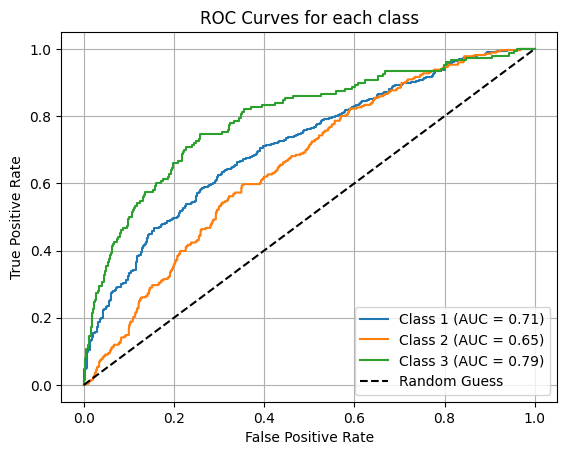


Mean F1 Score: 0.4618
Balanced Accuracy: 0.5394
Average AUPRC: 0.5078

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.43      0.58       912
           1       0.28      0.67      0.40       276
           2       0.35      0.51      0.41       150

    accuracy                           0.49      1338
   macro avg       0.50      0.54      0.46      1338
weighted avg       0.69      0.49      0.52      1338

Fold No: 3
Epoch [1/100], Loss: 1.1368, Accuracy: 0.3193
Validation Loss: 1.0036, Validation Accuracy: 0.3322
Epoch [2/100], Loss: 1.1138, Accuracy: 0.3333
Validation Loss: 1.1003, Validation Accuracy: 0.4883
Epoch [3/100], Loss: 1.0977, Accuracy: 0.3826
Validation Loss: 1.0081, Validation Accuracy: 0.4465
Epoch [4/100], Loss: 1.0871, Accuracy: 0.4433
Validation Loss: 1.0102, Validation Accuracy: 0.4608
Epoch [5/100], Loss: 1.0733, Accuracy: 0.4389
Validation Loss: 1.2442, Validation Accuracy: 0.4967
Epoch [6/100], Los

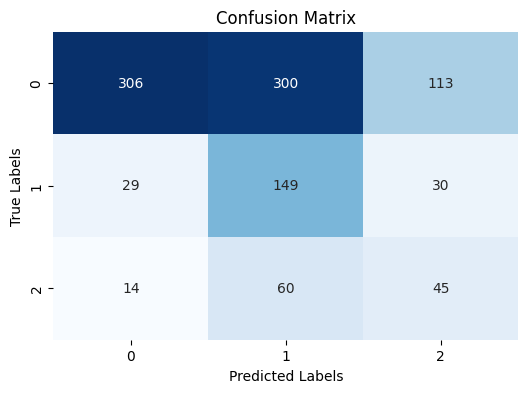


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 306/719 (42.56%)
Class 1: Correct Predictions / Total True Samples = 149/208 (71.63%)
Class 2: Correct Predictions / Total True Samples = 45/119 (37.82%)

Precision-Recall Curves:


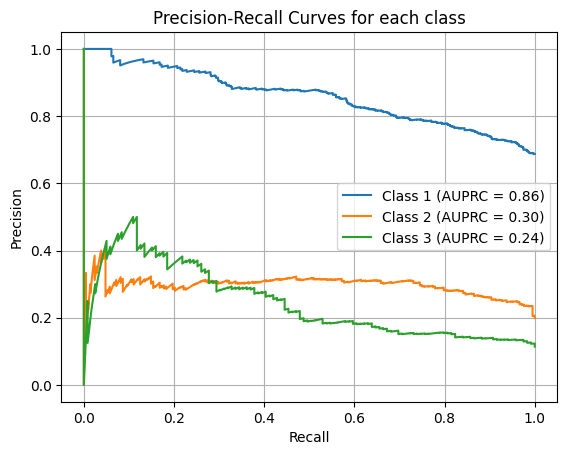


ROC Curves:


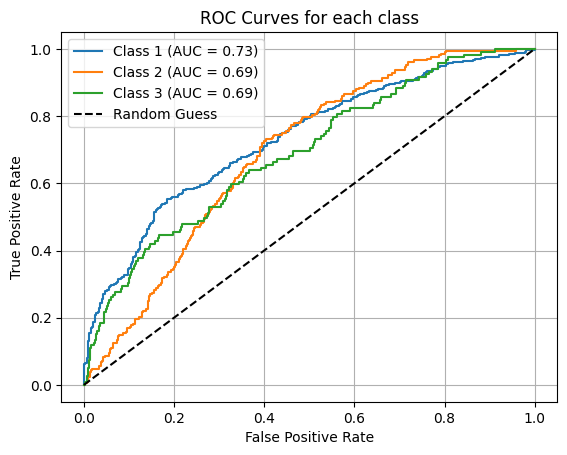


Mean F1 Score: 0.4273
Balanced Accuracy: 0.5067
Average AUPRC: 0.4650

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.43      0.57       719
           1       0.29      0.72      0.42       208
           2       0.24      0.38      0.29       119

    accuracy                           0.48      1046
   macro avg       0.47      0.51      0.43      1046
weighted avg       0.69      0.48      0.51      1046

Fold No: 4
Epoch [1/100], Loss: 1.1110, Accuracy: 0.3882
Validation Loss: 1.1386, Validation Accuracy: 0.3989
Epoch [2/100], Loss: 1.1038, Accuracy: 0.3731
Validation Loss: 1.1101, Validation Accuracy: 0.3580
Epoch [3/100], Loss: 1.1149, Accuracy: 0.3864
Validation Loss: 1.0434, Validation Accuracy: 0.3663
Epoch [4/100], Loss: 1.0718, Accuracy: 0.4527
Validation Loss: 1.0806, Validation Accuracy: 0.4371
Epoch [5/100], Loss: 1.0619, Accuracy: 0.4624
Validation Loss: 0.9983, Validation Accuracy: 0.4713
Epoch [6/100], Los

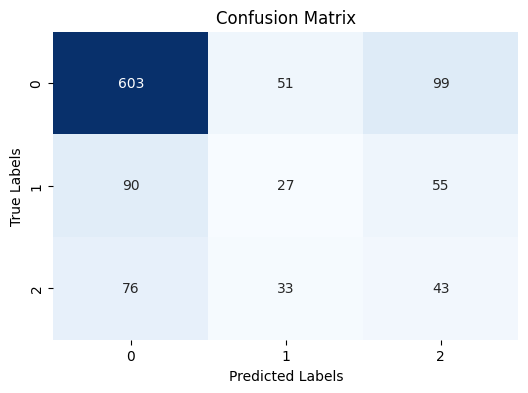


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 603/753 (80.08%)
Class 1: Correct Predictions / Total True Samples = 27/172 (15.70%)
Class 2: Correct Predictions / Total True Samples = 43/152 (28.29%)

Precision-Recall Curves:


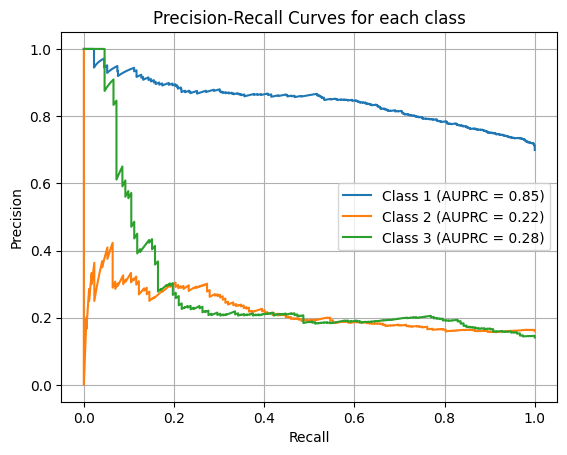


ROC Curves:


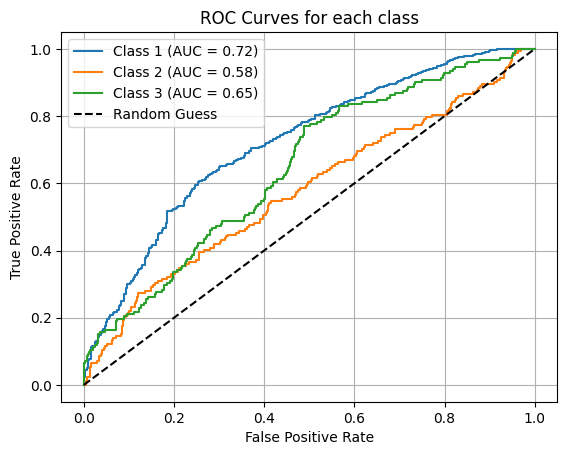


Mean F1 Score: 0.4099
Balanced Accuracy: 0.4136
Average AUPRC: 0.4478

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.80      0.79       753
           1       0.24      0.16      0.19       172
           2       0.22      0.28      0.25       152

    accuracy                           0.62      1077
   macro avg       0.42      0.41      0.41      1077
weighted avg       0.62      0.62      0.62      1077

Fold No: 5
Epoch [1/100], Loss: 1.1164, Accuracy: 0.3619
Validation Loss: 1.1290, Validation Accuracy: 0.3008
Epoch [2/100], Loss: 1.0894, Accuracy: 0.4329
Validation Loss: 1.1158, Validation Accuracy: 0.3763
Epoch [3/100], Loss: 1.0855, Accuracy: 0.4300
Validation Loss: 1.0471, Validation Accuracy: 0.4497
Epoch [4/100], Loss: 1.0601, Accuracy: 0.4734
Validation Loss: 1.0037, Validation Accuracy: 0.4286
Epoch [5/100], Loss: 1.0537, Accuracy: 0.4961
Validation Loss: 1.0310, Validation Accuracy: 0.4341
Epoch [6/100], Los

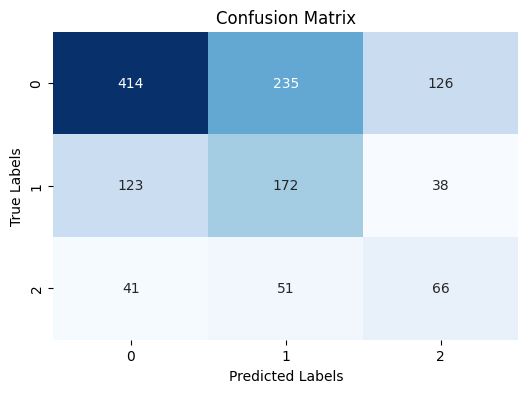


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 414/775 (53.42%)
Class 1: Correct Predictions / Total True Samples = 172/333 (51.65%)
Class 2: Correct Predictions / Total True Samples = 66/158 (41.77%)

Precision-Recall Curves:


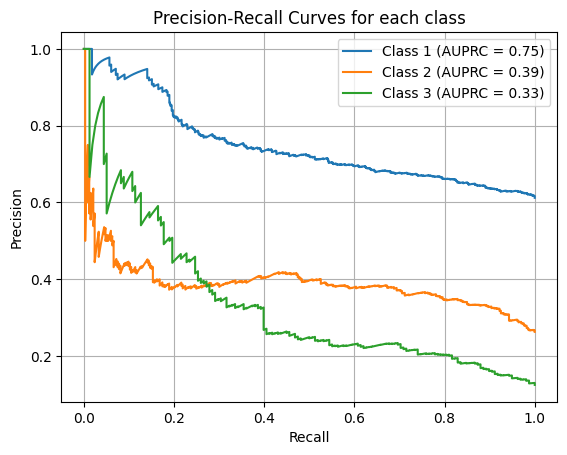


ROC Curves:


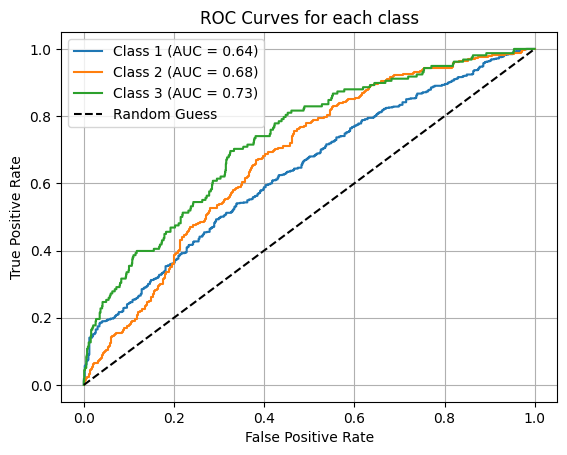


Mean F1 Score: 0.4624
Balanced Accuracy: 0.4895
Average AUPRC: 0.4888

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.53      0.61       775
           1       0.38      0.52      0.43       333
           2       0.29      0.42      0.34       158

    accuracy                           0.52      1266
   macro avg       0.46      0.49      0.46      1266
weighted avg       0.57      0.52      0.53      1266

Accuracy for each fold: [np.float64(0.4443931959758001), np.float64(0.5393891431477243), np.float64(0.5066961710328723), np.float64(0.4135560979257186), np.float64(0.4894771946303183)]
AUPRC for each fold: [np.float64(0.42537077597118095), np.float64(0.5077585814136373), np.float64(0.46496814443299356), np.float64(0.44780400030168127), np.float64(0.488846385530242)]
Average AUPRC across all folds: 0.46694957752994704
Average Balanced Accuracy across all folds: 0.4787023605424868
Results saved to D:\PYTHONIG\newwindow\N

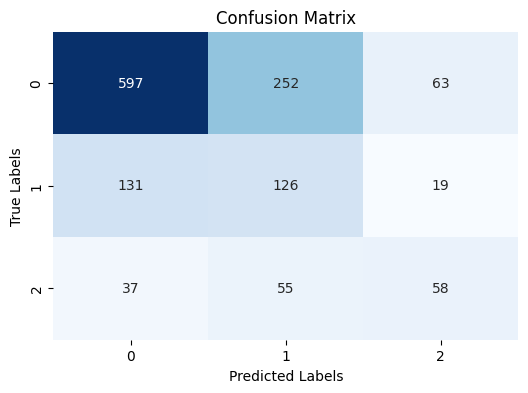


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 597/912 (65.46%)
Class 1: Correct Predictions / Total True Samples = 126/276 (45.65%)
Class 2: Correct Predictions / Total True Samples = 58/150 (38.67%)

Precision-Recall Curves:


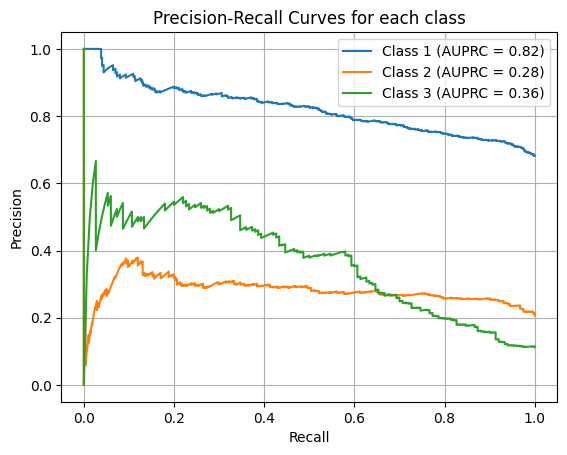


ROC Curves:


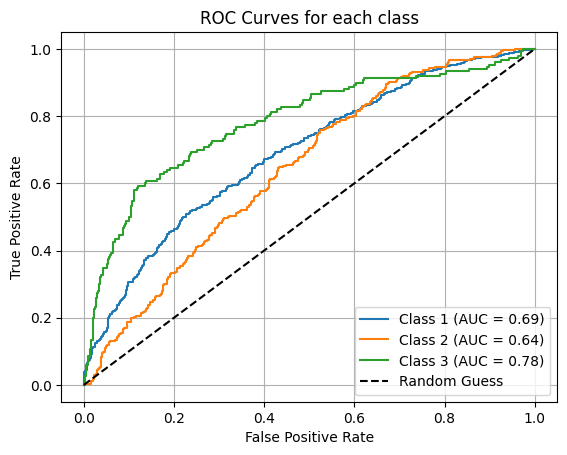


Mean F1 Score: 0.4891
Balanced Accuracy: 0.4993
Average AUPRC: 0.4879

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.65      0.71       912
           1       0.29      0.46      0.36       276
           2       0.41      0.39      0.40       150

    accuracy                           0.58      1338
   macro avg       0.50      0.50      0.49      1338
weighted avg       0.64      0.58      0.60      1338

Fold No: 2
Epoch [1/100], Loss: 1.1167, Accuracy: 0.3528
Validation Loss: 1.1243, Validation Accuracy: 0.4812
Epoch [2/100], Loss: 1.1000, Accuracy: 0.3598
Validation Loss: 1.0919, Validation Accuracy: 0.4123
Epoch [3/100], Loss: 1.0957, Accuracy: 0.3823
Validation Loss: 1.1244, Validation Accuracy: 0.4977
Epoch [4/100], Loss: 1.0822, Accuracy: 0.4406
Validation Loss: 1.1173, Validation Accuracy: 0.4995
Epoch [5/100], Loss: 1.0759, Accuracy: 0.4429
Validation Loss: 1.2090, Validation Accuracy: 0.3796
Epoch [6/100], Los

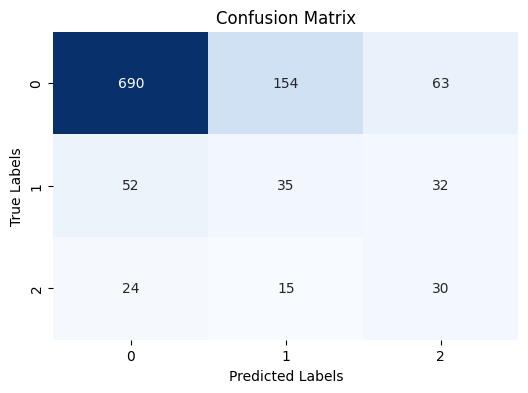


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 690/907 (76.07%)
Class 1: Correct Predictions / Total True Samples = 35/119 (29.41%)
Class 2: Correct Predictions / Total True Samples = 30/69 (43.48%)

Precision-Recall Curves:


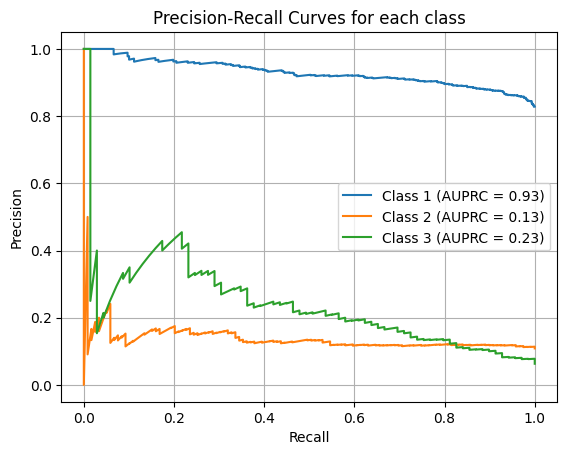


ROC Curves:


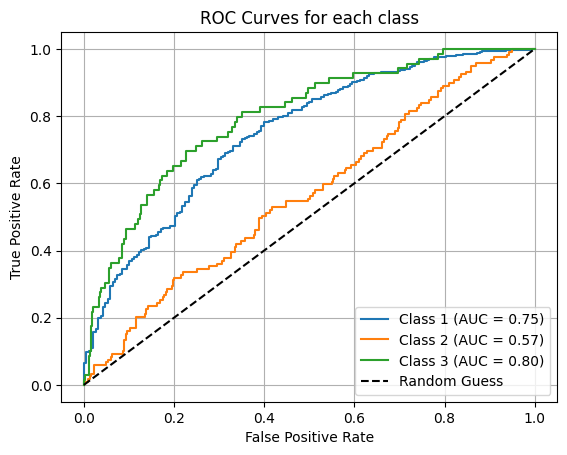


Mean F1 Score: 0.4503
Balanced Accuracy: 0.4965
Average AUPRC: 0.4325

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.76      0.82       907
           1       0.17      0.29      0.22       119
           2       0.24      0.43      0.31        69

    accuracy                           0.69      1095
   macro avg       0.44      0.50      0.45      1095
weighted avg       0.78      0.69      0.73      1095

Fold No: 3
Epoch [1/100], Loss: 1.1022, Accuracy: 0.3973
Validation Loss: 1.0463, Validation Accuracy: 0.3460
Epoch [2/100], Loss: 1.1025, Accuracy: 0.3778
Validation Loss: 1.0576, Validation Accuracy: 0.4210
Epoch [3/100], Loss: 1.0732, Accuracy: 0.4520
Validation Loss: 0.9066, Validation Accuracy: 0.3961
Epoch [4/100], Loss: 1.0631, Accuracy: 0.4621
Validation Loss: 1.0091, Validation Accuracy: 0.4263
Epoch [5/100], Loss: 1.0509, Accuracy: 0.4973
Validation Loss: 1.1027, Validation Accuracy: 0.4272
Epoch [6/100], Los

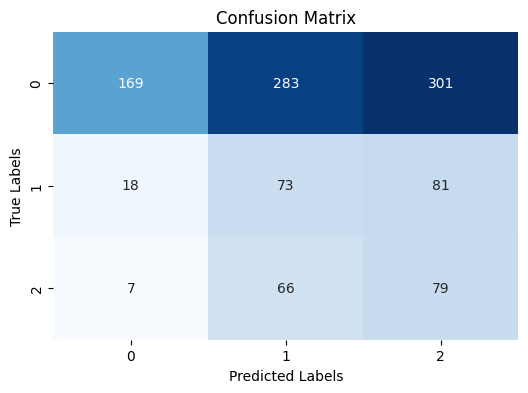


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 169/753 (22.44%)
Class 1: Correct Predictions / Total True Samples = 73/172 (42.44%)
Class 2: Correct Predictions / Total True Samples = 79/152 (51.97%)

Precision-Recall Curves:


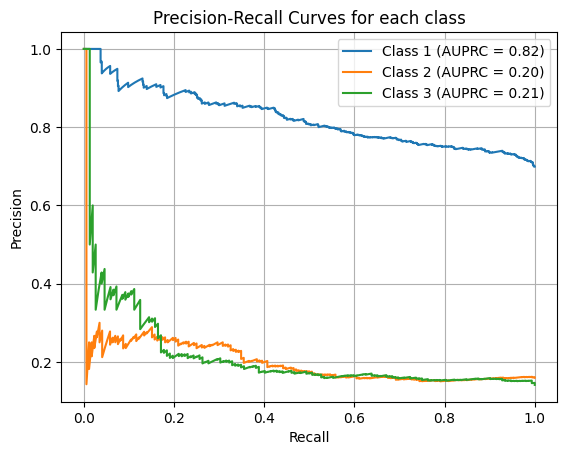


ROC Curves:


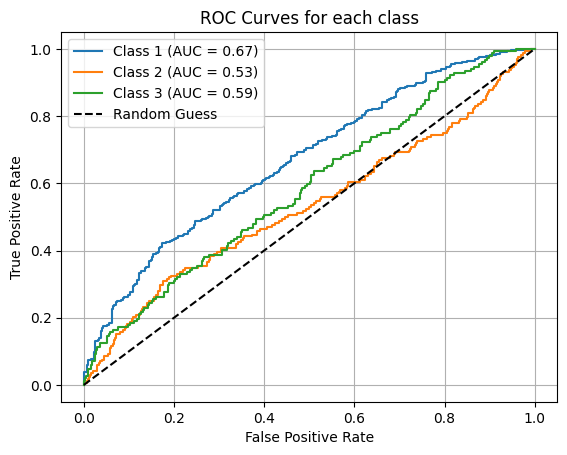


Mean F1 Score: 0.2868
Balanced Accuracy: 0.3895
Average AUPRC: 0.4114

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.22      0.36       753
           1       0.17      0.42      0.25       172
           2       0.17      0.52      0.26       152

    accuracy                           0.30      1077
   macro avg       0.41      0.39      0.29      1077
weighted avg       0.66      0.30      0.33      1077

Fold No: 4
Epoch [1/100], Loss: 1.1262, Accuracy: 0.3176
Validation Loss: 1.1590, Validation Accuracy: 0.3062
Epoch [2/100], Loss: 1.0903, Accuracy: 0.4112
Validation Loss: 1.1586, Validation Accuracy: 0.3756
Epoch [3/100], Loss: 1.0830, Accuracy: 0.4389
Validation Loss: 0.9704, Validation Accuracy: 0.3886
Epoch [4/100], Loss: 1.0606, Accuracy: 0.5000
Validation Loss: 1.1011, Validation Accuracy: 0.4328
Epoch [5/100], Loss: 1.0483, Accuracy: 0.5010
Validation Loss: 0.9905, Validation Accuracy: 0.4272
Epoch [6/100], Los

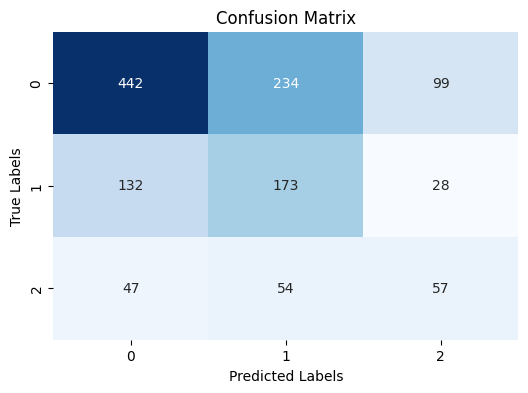


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 442/775 (57.03%)
Class 1: Correct Predictions / Total True Samples = 173/333 (51.95%)
Class 2: Correct Predictions / Total True Samples = 57/158 (36.08%)

Precision-Recall Curves:


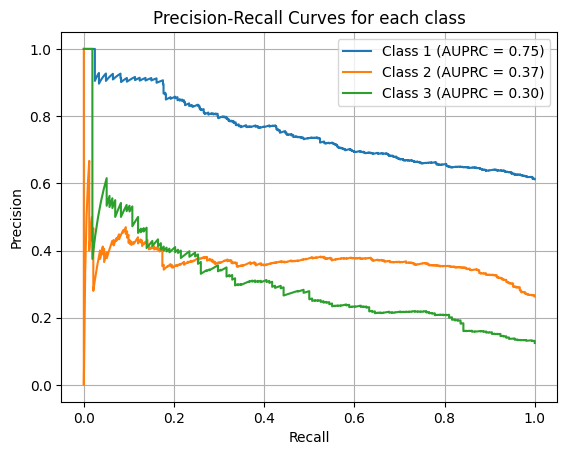


ROC Curves:


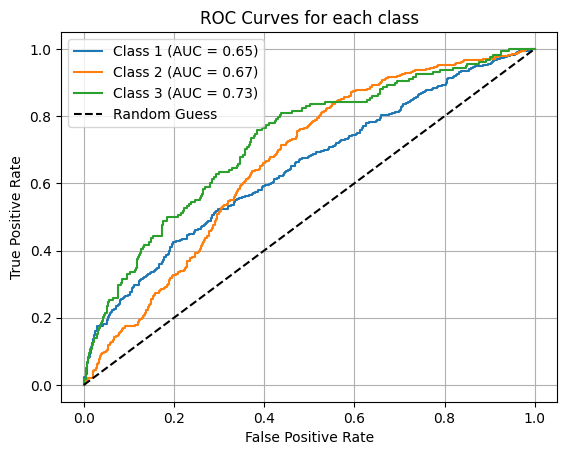


Mean F1 Score: 0.4674
Balanced Accuracy: 0.4835
Average AUPRC: 0.4736

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.57      0.63       775
           1       0.38      0.52      0.44       333
           2       0.31      0.36      0.33       158

    accuracy                           0.53      1266
   macro avg       0.47      0.48      0.47      1266
weighted avg       0.57      0.53      0.54      1266

Fold No: 5
Epoch [1/100], Loss: 1.1192, Accuracy: 0.3486
Validation Loss: 1.0414, Validation Accuracy: 0.3273
Epoch [2/100], Loss: 1.1001, Accuracy: 0.4025
Validation Loss: 1.0914, Validation Accuracy: 0.4046
Epoch [3/100], Loss: 1.0796, Accuracy: 0.4367
Validation Loss: 1.0159, Validation Accuracy: 0.3878
Epoch [4/100], Loss: 1.0755, Accuracy: 0.4438
Validation Loss: 1.0565, Validation Accuracy: 0.4169
Epoch [5/100], Loss: 1.0760, Accuracy: 0.4582
Validation Loss: 1.0101, Validation Accuracy: 0.4013
Epoch [6/100], Los

In [ ]:
import pandas as pd
import os
import datetime


import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, auc


top_params = [
    {
        'n_patches': 28,
        'embed_dim': 128,
        'learning_rate': 3.6467910524712975e-05,
        'weight_decay': 1.1407515349694686e-05,
        'batch_size': 32,
        'num_transformer_blocks': 6,
        'num_heads': 8,
        'accuracy': 0.4555
    },
    {
        'n_patches': 14,
        'embed_dim': 64,
        'learning_rate': 2.9195609817654728e-05,
        'weight_decay': 6.40075182717267e-05,
        'batch_size': 16,
        'num_transformer_blocks': 4,
        'num_heads': 4,
        'accuracy': 0.4549
    },
    {
        'n_patches': 14,
        'embed_dim': 256,
        'learning_rate': 4.658629178609918e-05,
        'weight_decay': 2.145402908576287e-05,
        'batch_size': 16,
        'num_transformer_blocks': 4,
        'num_heads': 4,
        'accuracy': 0.4516
    },
    {
        'n_patches': 14,
        'embed_dim': 256,
        'learning_rate': 2.5893793649076787e-05,
        'weight_decay': 3.284975130996957e-05,
        'batch_size': 32,
        'num_transformer_blocks': 4,
        'num_heads': 4,
        'accuracy': 0.4498
    },
    {
        'n_patches': 14,
        'embed_dim': 64,
        'learning_rate': 1.303548468658277e-05,
        'weight_decay': 2.2203605523088946e-05,
        'batch_size': 32,
        'num_transformer_blocks': 2,
        'num_heads': 4,
        'accuracy': 0.4497
    }
]

for param_id in range(len(top_params)):
    
    print(f"Running experiment with parameters: {top_params[param_id]}")
    print("_"*50)
    print("_"*50)
    print("_"*50)
    print("_"*50)
    print("_"*50)    
    
    # Fold indices and other configurations
    num_folds = 5
    fold_indices = np.random.permutation(np.arange(num_folds))
    val_fold_indices = np.roll(fold_indices, 1)

    test_folds_chosen = []
    val_folds_chosen = []
    fold_confusion_matrices = []  # To store confusion matrices for each fold
    fold_accuracies = []  # To store balanced accuracy for each fold
    fold_auprcs = []  # To store AUPRC for each fold

    # Model and training configurations
    num_classes = 3

    epochs = 100
    input_shape = (3, 224,224)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'


    n_patches = top_params[param_id]['n_patches']
    hidden_size = top_params[param_id]['embed_dim']
    num_transformer_blocks = top_params[param_id]['num_transformer_blocks']
    weight_decay = top_params[param_id]['weight_decay']
    num_heads = top_params[param_id]['num_heads']
    learning_rate = top_params[param_id]['learning_rate']
    factor = 1
    batch_size = top_params[param_id]['batch_size']

    def save_results_to_csv(fold_accuracies, fold_auprcs, fold_confusion_matrices, model_info, csv_path=r"F:\CODING\py\newnotebooks\results.csv"):
        """
        Save all results from the current experiment to a CSV file
        
        Parameters:
        - fold_accuracies: list of balanced accuracy scores for each fold
        - fold_auprcs: list of AUPRC scores for each fold
        - fold_confusion_matrices: list of confusion matrices for each fold
        - model_info: string with model architecture description
        - csv_path: path to the CSV file to save results
        """
        # Current time for experiment identification
        timestamp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        
        # Prepare data for the DataFrame
        data = {
            "timestamp": timestamp,
            "model_info": model_info,
            "num_classes": num_classes,
            "learning_rate": learning_rate,
            "epochs": epochs,
            "mean_balanced_accuracy": np.mean(fold_accuracies),
            "std_balanced_accuracy": np.std(fold_accuracies),
            "mean_auprc": np.mean(fold_auprcs),
            "std_auprc": np.std(fold_auprcs),
        }
        
        # Add individual fold results
        for i, (acc, auprc) in enumerate(zip(fold_accuracies, fold_auprcs)):
            data[f"fold_{i+1}_accuracy"] = acc
            data[f"fold_{i+1}_auprc"] = auprc
        
        # Add confusion matrix info
        for i, cm in enumerate(fold_confusion_matrices):
            data[f"fold_{i+1}_confusion_matrix"] = str(cm)
        
        # Create DataFrame and append to CSV
        df = pd.DataFrame([data])
        
        # Check if file exists
        file_exists = os.path.isfile(csv_path)
        
        # Save to CSV
        if file_exists:
            df.to_csv(csv_path, mode='a', header=False, index=False)
        else:
            df.to_csv(csv_path, mode='w', header=True, index=False)
        
        print(f"Results saved to {csv_path}")
        




    # Training loop for cross-validation
    for fold_idx in range(num_folds):
        print(f'Fold No: {fold_idx + 1}')
        
        # Initialize model, loss, and optimizer
        fold_model = vit(
            input_size=input_shape, 
            n_patches=n_patches, 
            hidden_size=hidden_size, 
            num_classes=num_classes,
            num_transformer_blocks=num_transformer_blocks,
            num_heads=num_heads
        ).to(device)
        fold_model.to(device)
        
        criterion = nn.CrossEntropyLoss(label_smoothing=0.3)
        optimizer = optim.Adam(fold_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        
        # Split data into train, validation, and test sets
        test_fold = fold_indices[fold_idx]
        val_fold = val_fold_indices[fold_idx]
        train_folds = [fold for fold in fold_indices if fold != test_fold and fold != val_fold]

        train_data = np.concatenate([eeg_folds[j] for j in train_folds])
        train_labels = np.concatenate([labels_folds[j] for j in train_folds])
        train_data = train_data.transpose(0, 3, 1, 2)  # Transpose to match PyTorch input format

        test_folds_chosen.append(test_fold)
        val_folds_chosen.append(val_fold)
        
        early_stopping = EarlyStopping(patience=10)
        
        # Training loop
        for epoch in range(epochs):
            balanced_train_data, balanced_train_labels = data_balancer(train_data, train_labels, factor=1)

            train_dataset = TensorDataset(
                torch.tensor(balanced_train_data, dtype=torch.float32).to(device),
                torch.tensor(balanced_train_labels, dtype=torch.long).to(device)
            )
            train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
            
            fold_model.train()
            running_loss = 0.0
            all_preds = []
            all_labels = []
            
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = fold_model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                
            epoch_loss = running_loss / len(train_loader)
            epoch_acc = balanced_accuracy_score(all_labels, all_preds)
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

            # Validation loop
            val_data = eeg_folds[val_fold].transpose(0, 3, 1, 2)
            val_labels = labels_folds[val_fold]
            val_dataset = TensorDataset(
                torch.tensor(val_data, dtype=torch.float32).to(device),
                torch.tensor(val_labels, dtype=torch.long).to(device)
            )
            val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False)

            fold_model.eval()
            val_loss = 0.0
            val_preds = []
            val_labels_list = []

            with torch.no_grad():
                for val_inputs, val_labels in val_loader:
                    val_outputs = fold_model(val_inputs)
                    loss = criterion(val_outputs, val_labels)
                    val_loss += loss.item()

                    _, val_batch_preds = torch.max(val_outputs, 1)
                    val_preds.extend(val_batch_preds.cpu().numpy())
                    val_labels_list.extend(val_labels.cpu().numpy())

            val_loss /= len(val_loader)
            val_acc = balanced_accuracy_score(val_labels_list, val_preds)
            print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')

            early_stopping(val_loss, fold_model)
            if early_stopping.early_stop:
                print("Early stopping")
                break

        # Load the best model
        early_stopping.load_best_model(fold_model)

        # Test loop
        test_data = eeg_folds[test_fold].transpose(0, 3, 1, 2)
        test_labels = labels_folds[test_fold]
        test_dataset = TensorDataset(
            torch.tensor(test_data, dtype=torch.float32).to(device),
            torch.tensor(test_labels, dtype=torch.long).to(device)
        )
        test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

        fold_model.eval()
        test_probs = []
        test_preds = []
        test_labels_list = []

        with torch.no_grad():
            for test_inputs, test_labels in test_loader:
                test_outputs = fold_model(test_inputs)
                probabilities = torch.softmax(test_outputs, dim=1)
                test_probs.extend(probabilities.cpu().numpy())
                _, preds = torch.max(probabilities, 1)
                test_preds.extend(preds.cpu().numpy())
                test_labels_list.extend(test_labels.cpu().numpy())

        # Compute metrics
        test_acc = balanced_accuracy_score(test_labels_list, test_preds)
        fold_accuracies.append(test_acc)

        cm = confusion_matrix(test_labels_list, test_preds)
        fold_confusion_matrices.append(cm)

        test_labels_binarized = label_binarize(test_labels_list, classes=np.arange(num_classes))
        test_auprcs = []
        for class_idx in range(num_classes):
            precision, recall, _ = precision_recall_curve(test_labels_binarized[:, class_idx], np.array(test_probs)[:, class_idx])
            auprc = auc(recall, precision)
            test_auprcs.append(auprc)

        mean_test_auprc = np.mean(test_auprcs)
        fold_auprcs.append(mean_test_auprc)

        print(f'Test Fold {fold_idx + 1}, Mean AUPRC: {mean_test_auprc:.4f}, Balanced Accuracy: {test_acc:.4f}')

        # Use the plot_metrics function to visualize metrics
        plot_metrics(np.array(test_labels_list), np.array(test_probs), n_classes=num_classes)

    # Final metrics across all folds
    average_auprc = np.mean(fold_auprcs)
    mean_accuracy = np.mean(fold_accuracies)
    print(f'Accuracy for each fold: {fold_accuracies}')
    print(f'AUPRC for each fold: {fold_auprcs}')
    print(f'Average AUPRC across all folds: {average_auprc}')
    print(f'Average Balanced Accuracy across all folds: {mean_accuracy}')

    model_description = f"ViT top5 params hyper{param_id} 3 classes"
    save_results_to_csv(fold_accuracies, fold_auprcs, fold_confusion_matrices, model_description,csv_path=r"D:\PYTHONIG\newwindow\NOTEBOOKS_2025\aprilmay2025\newnotebooks\results.csv")

    print("_"*50)
    print("_"*50)
    print("_"*50)
    print("_"*50)
    print("_"*50)
    print("_"*50)
    print("_"*50)
    print("_"*50)
    print("_"*50)
    print("_"*50)    



Running experiment with parameters: {'n_patches': 14, 'embed_dim': 256, 'learning_rate': 2.5893793649076787e-05, 'weight_decay': 3.284975130996957e-05, 'batch_size': 32, 'num_transformer_blocks': 4, 'num_heads': 4, 'accuracy': 0.4498}
__________________________________________________
__________________________________________________
__________________________________________________
__________________________________________________
__________________________________________________
Fold No: 1
Epoch [1/100], Loss: 1.1250, Accuracy: 0.3422
Validation Loss: 1.1830, Validation Accuracy: 0.2948
Epoch [2/100], Loss: 1.0911, Accuracy: 0.3895
Validation Loss: 1.0262, Validation Accuracy: 0.3473
Epoch [3/100], Loss: 1.0884, Accuracy: 0.4181
Validation Loss: 1.1483, Validation Accuracy: 0.3511
Epoch [4/100], Loss: 1.0650, Accuracy: 0.4813
Validation Loss: 1.1086, Validation Accuracy: 0.3848
Epoch [5/100], Loss: 1.0557, Accuracy: 0.4842
Validation Loss: 1.0577, Validation Accuracy: 0.4305
Epoc

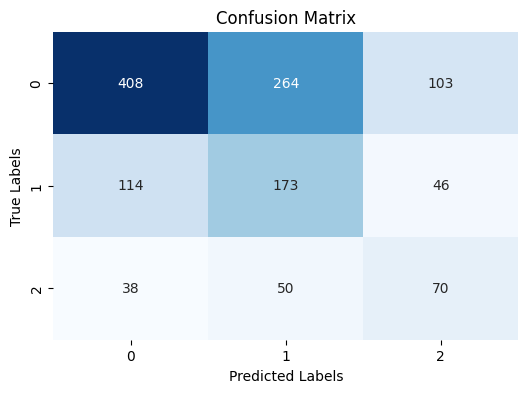


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 408/775 (52.65%)
Class 1: Correct Predictions / Total True Samples = 173/333 (51.95%)
Class 2: Correct Predictions / Total True Samples = 70/158 (44.30%)

Precision-Recall Curves:


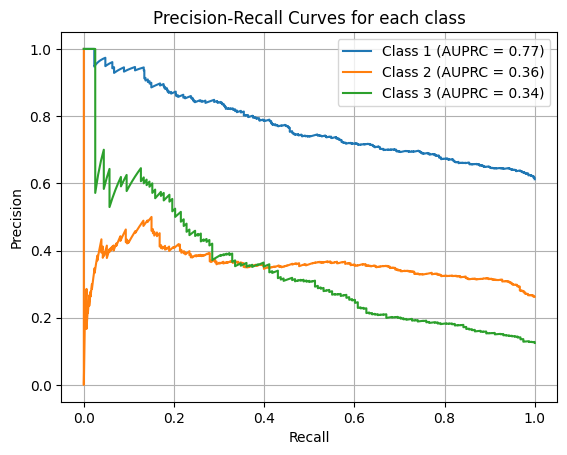


ROC Curves:


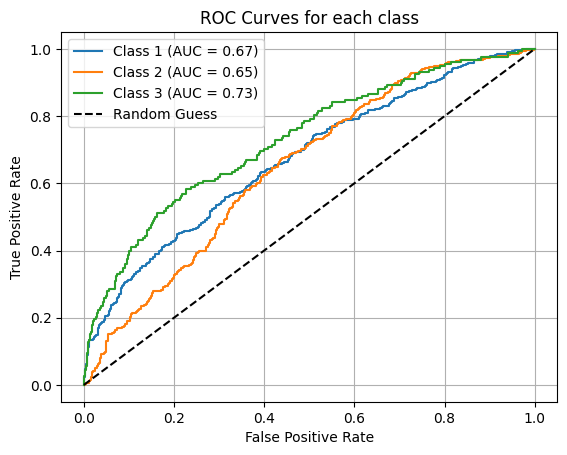


Mean F1 Score: 0.4682
Balanced Accuracy: 0.4963
Average AUPRC: 0.4908

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.53      0.61       775
           1       0.36      0.52      0.42       333
           2       0.32      0.44      0.37       158

    accuracy                           0.51      1266
   macro avg       0.47      0.50      0.47      1266
weighted avg       0.58      0.51      0.53      1266

Fold No: 2
Epoch [1/100], Loss: 1.1183, Accuracy: 0.3647
Validation Loss: 1.0754, Validation Accuracy: 0.3306
Epoch [2/100], Loss: 1.1114, Accuracy: 0.3412
Validation Loss: 1.0511, Validation Accuracy: 0.3375
Epoch [3/100], Loss: 1.0952, Accuracy: 0.3863
Validation Loss: 1.1557, Validation Accuracy: 0.3606
Epoch [4/100], Loss: 1.0709, Accuracy: 0.4402
Validation Loss: 1.0575, Validation Accuracy: 0.4280
Epoch [5/100], Loss: 1.0650, Accuracy: 0.4480
Validation Loss: 1.0327, Validation Accuracy: 0.4077
Epoch [6/100], Los

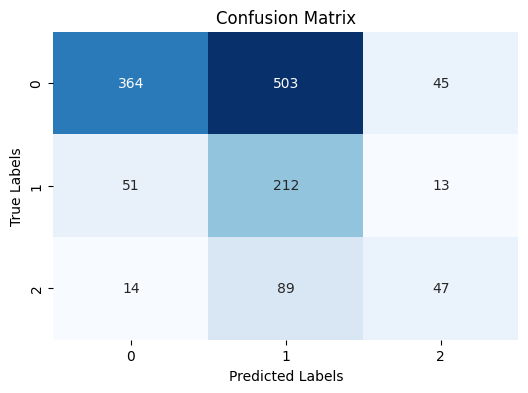


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 364/912 (39.91%)
Class 1: Correct Predictions / Total True Samples = 212/276 (76.81%)
Class 2: Correct Predictions / Total True Samples = 47/150 (31.33%)

Precision-Recall Curves:


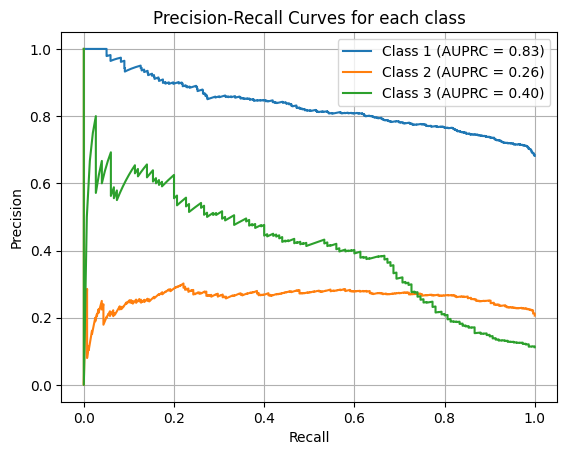


ROC Curves:


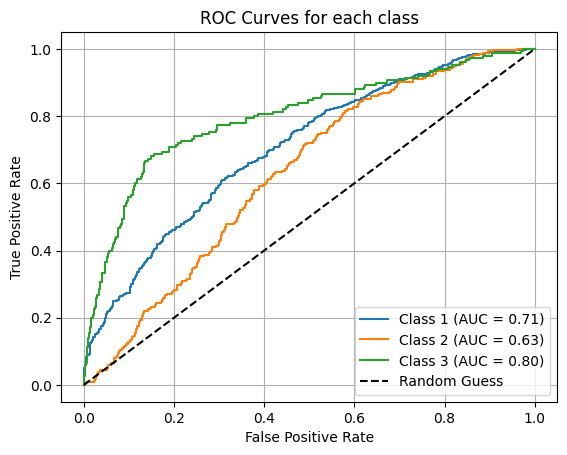


Mean F1 Score: 0.4347
Balanced Accuracy: 0.4935
Average AUPRC: 0.4978

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.40      0.54       912
           1       0.26      0.77      0.39       276
           2       0.45      0.31      0.37       150

    accuracy                           0.47      1338
   macro avg       0.52      0.49      0.43      1338
weighted avg       0.68      0.47      0.49      1338

Fold No: 3
Epoch [1/100], Loss: 1.1211, Accuracy: 0.3450
Validation Loss: 1.0817, Validation Accuracy: 0.4011
Epoch [2/100], Loss: 1.1087, Accuracy: 0.3512
Validation Loss: 1.0911, Validation Accuracy: 0.4744
Epoch [3/100], Loss: 1.0951, Accuracy: 0.3893
Validation Loss: 1.1783, Validation Accuracy: 0.4921
Epoch [4/100], Loss: 1.0825, Accuracy: 0.4211
Validation Loss: 1.1019, Validation Accuracy: 0.4382
Epoch [5/100], Loss: 1.0803, Accuracy: 0.4328
Validation Loss: 1.0763, Validation Accuracy: 0.4547
Epoch [6/100], Los

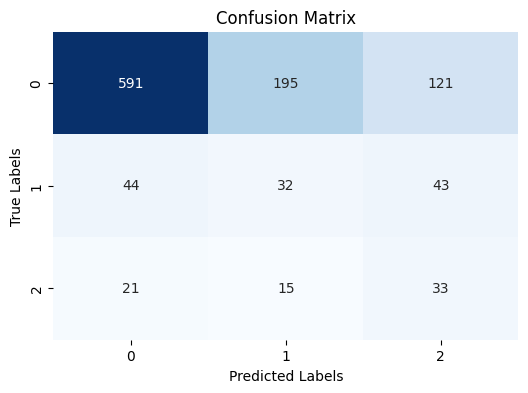


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 591/907 (65.16%)
Class 1: Correct Predictions / Total True Samples = 32/119 (26.89%)
Class 2: Correct Predictions / Total True Samples = 33/69 (47.83%)

Precision-Recall Curves:


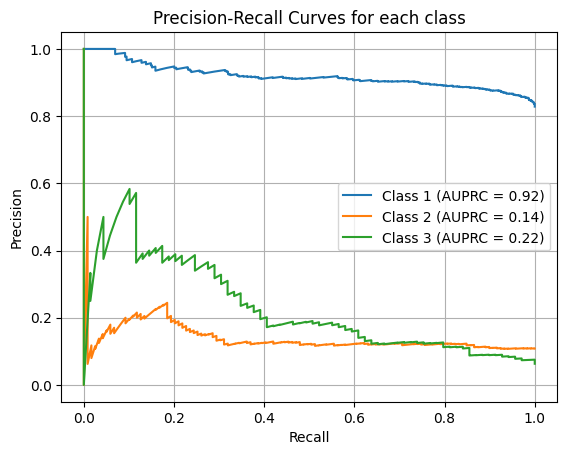


ROC Curves:


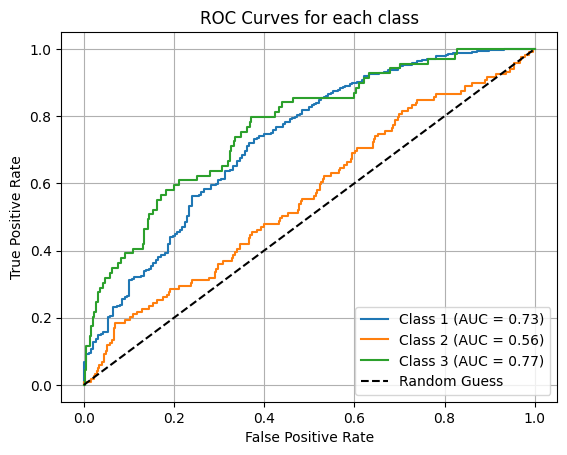


Mean F1 Score: 0.3939
Balanced Accuracy: 0.4663
Average AUPRC: 0.4264

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.65      0.76       907
           1       0.13      0.27      0.18       119
           2       0.17      0.48      0.25        69

    accuracy                           0.60      1095
   macro avg       0.40      0.47      0.39      1095
weighted avg       0.77      0.60      0.66      1095

Fold No: 4
Epoch [1/100], Loss: 1.1239, Accuracy: 0.3543
Validation Loss: 1.0407, Validation Accuracy: 0.3176
Epoch [2/100], Loss: 1.1051, Accuracy: 0.3696
Validation Loss: 1.1425, Validation Accuracy: 0.3926
Epoch [3/100], Loss: 1.0966, Accuracy: 0.3993
Validation Loss: 1.0882, Validation Accuracy: 0.4551
Epoch [4/100], Loss: 1.0881, Accuracy: 0.4109
Validation Loss: 1.0291, Validation Accuracy: 0.4952
Epoch [5/100], Loss: 1.0764, Accuracy: 0.4442
Validation Loss: 1.2890, Validation Accuracy: 0.4265
Epoch [6/100], Los

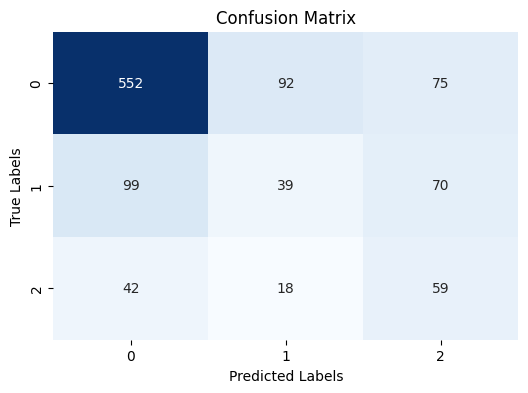


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 552/719 (76.77%)
Class 1: Correct Predictions / Total True Samples = 39/208 (18.75%)
Class 2: Correct Predictions / Total True Samples = 59/119 (49.58%)

Precision-Recall Curves:


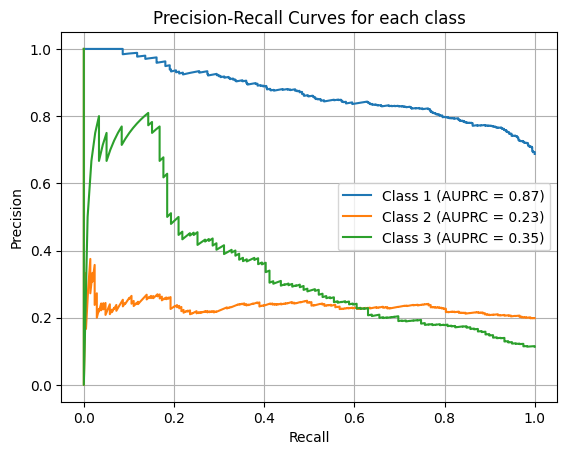


ROC Curves:


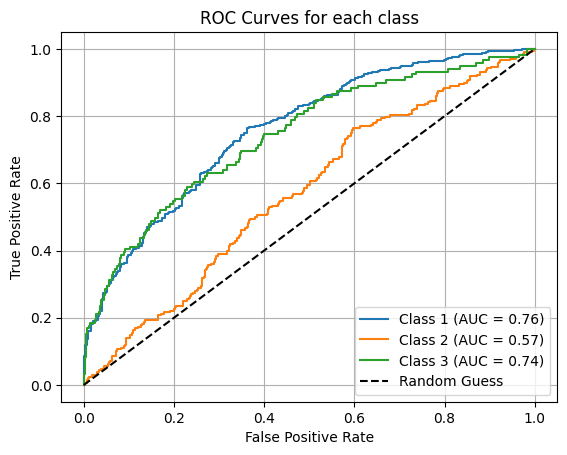


Mean F1 Score: 0.4552
Balanced Accuracy: 0.4837
Average AUPRC: 0.4826

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.77      0.78       719
           1       0.26      0.19      0.22       208
           2       0.29      0.50      0.37       119

    accuracy                           0.62      1046
   macro avg       0.45      0.48      0.46      1046
weighted avg       0.63      0.62      0.62      1046

Fold No: 5
Epoch [1/100], Loss: 1.1147, Accuracy: 0.3563
Validation Loss: 1.2008, Validation Accuracy: 0.3349
Epoch [2/100], Loss: 1.1078, Accuracy: 0.3811
Validation Loss: 1.1567, Validation Accuracy: 0.4100
Epoch [3/100], Loss: 1.1016, Accuracy: 0.3855
Validation Loss: 1.1342, Validation Accuracy: 0.3628
Epoch [4/100], Loss: 1.0830, Accuracy: 0.4156
Validation Loss: 1.1134, Validation Accuracy: 0.3977
Epoch [5/100], Loss: 1.0631, Accuracy: 0.4730
Validation Loss: 1.0249, Validation Accuracy: 0.5090
Epoch [6/100], Los

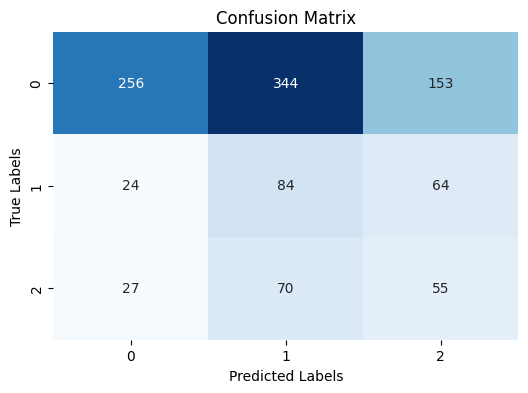


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 256/753 (34.00%)
Class 1: Correct Predictions / Total True Samples = 84/172 (48.84%)
Class 2: Correct Predictions / Total True Samples = 55/152 (36.18%)

Precision-Recall Curves:


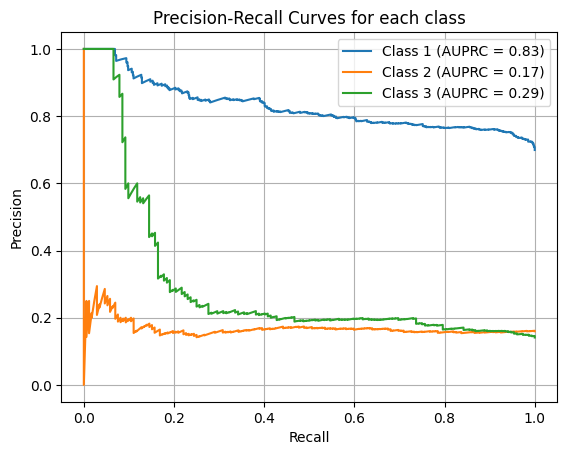


ROC Curves:


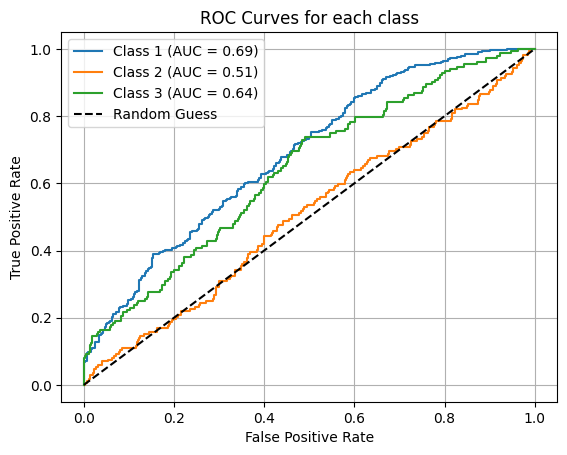


Mean F1 Score: 0.3311
Balanced Accuracy: 0.3967
Average AUPRC: 0.4294

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.34      0.48       753
           1       0.17      0.49      0.25       172
           2       0.20      0.36      0.26       152

    accuracy                           0.37      1077
   macro avg       0.40      0.40      0.33      1077
weighted avg       0.64      0.37      0.41      1077

Accuracy for each fold: [np.float64(0.4963363690354299), np.float64(0.49352402745995433), np.float64(0.4662557031824763), np.float64(0.48367709392519176), np.float64(0.3967292126204823)]
AUPRC for each fold: [np.float64(0.4907941267092319), np.float64(0.4978455074450929), np.float64(0.4264215807797531), np.float64(0.482580383849837), np.float64(0.4293780318211417)]
Average AUPRC across all folds: 0.46540392612101134
Average Balanced Accuracy across all folds: 0.46730448124470697
Results saved to D:\PYTHONIG\newwindow\N

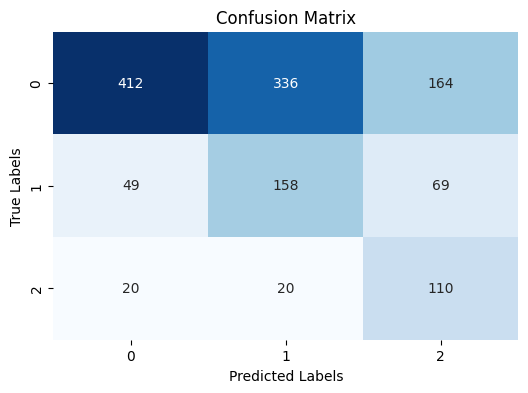


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 412/912 (45.18%)
Class 1: Correct Predictions / Total True Samples = 158/276 (57.25%)
Class 2: Correct Predictions / Total True Samples = 110/150 (73.33%)

Precision-Recall Curves:


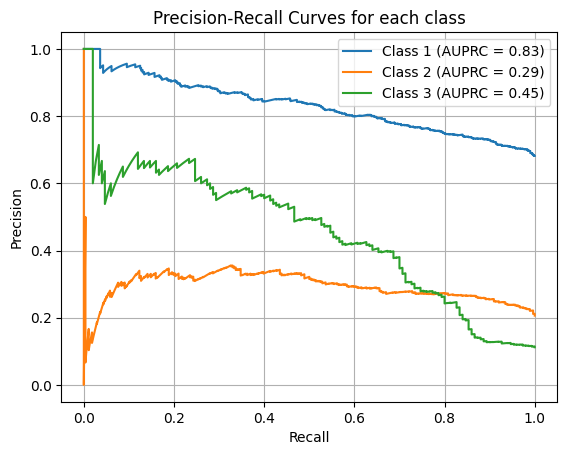


ROC Curves:


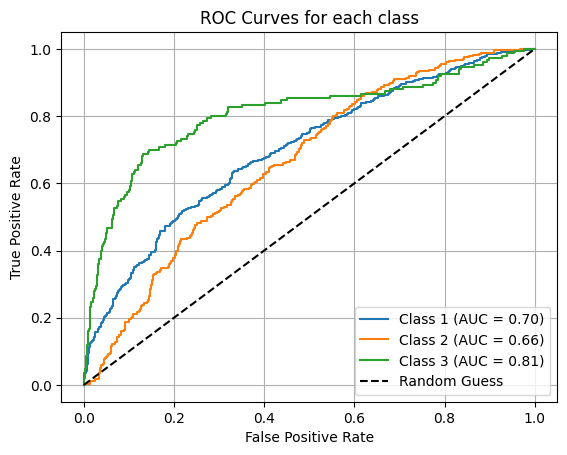


Mean F1 Score: 0.4793
Balanced Accuracy: 0.5859
Average AUPRC: 0.5251

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.45      0.59       912
           1       0.31      0.57      0.40       276
           2       0.32      0.73      0.45       150

    accuracy                           0.51      1338
   macro avg       0.49      0.59      0.48      1338
weighted avg       0.68      0.51      0.54      1338

Fold No: 2
Epoch [1/100], Loss: 1.1268, Accuracy: 0.3304
Validation Loss: 1.1040, Validation Accuracy: 0.3988
Epoch [2/100], Loss: 1.1065, Accuracy: 0.3186
Validation Loss: 1.0751, Validation Accuracy: 0.3311
Epoch [3/100], Loss: 1.1038, Accuracy: 0.3088
Validation Loss: 1.1010, Validation Accuracy: 0.4298
Epoch [4/100], Loss: 1.1001, Accuracy: 0.3549
Validation Loss: 1.1026, Validation Accuracy: 0.4545
Epoch [5/100], Loss: 1.1002, Accuracy: 0.3598
Validation Loss: 1.1092, Validation Accuracy: 0.4476
Epoch [6/100], Los

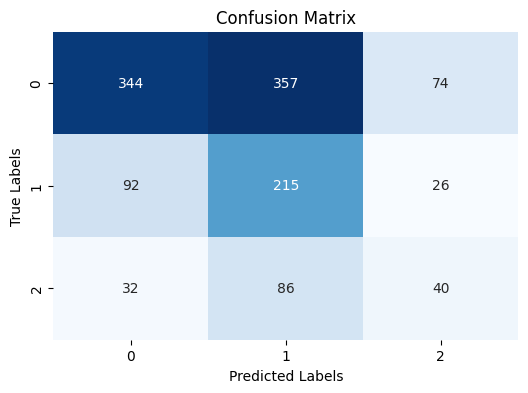


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 344/775 (44.39%)
Class 1: Correct Predictions / Total True Samples = 215/333 (64.56%)
Class 2: Correct Predictions / Total True Samples = 40/158 (25.32%)

Precision-Recall Curves:


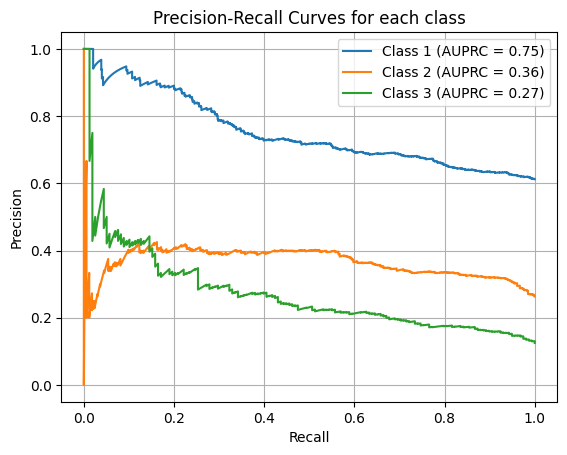


ROC Curves:


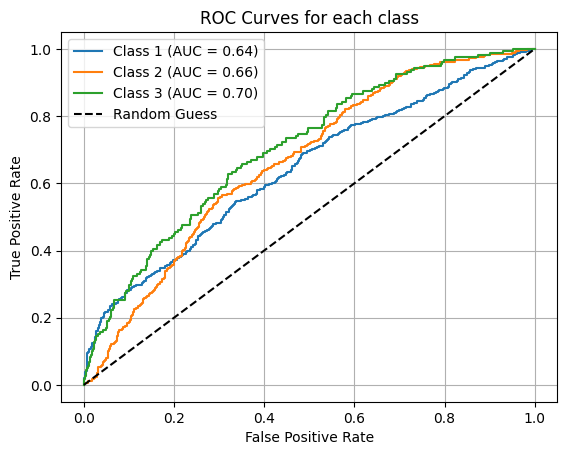


Mean F1 Score: 0.4186
Balanced Accuracy: 0.4476
Average AUPRC: 0.4616

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.44      0.55       775
           1       0.33      0.65      0.43       333
           2       0.29      0.25      0.27       158

    accuracy                           0.47      1266
   macro avg       0.45      0.45      0.42      1266
weighted avg       0.57      0.47      0.49      1266

Fold No: 3
Epoch [1/100], Loss: 1.1351, Accuracy: 0.3452
Validation Loss: 1.0851, Validation Accuracy: 0.3658
Epoch [2/100], Loss: 1.1000, Accuracy: 0.3748
Validation Loss: 1.0989, Validation Accuracy: 0.3597
Epoch [3/100], Loss: 1.0932, Accuracy: 0.3619
Validation Loss: 1.1172, Validation Accuracy: 0.3259
Epoch [4/100], Loss: 1.0915, Accuracy: 0.3807
Validation Loss: 1.0712, Validation Accuracy: 0.3500
Epoch [5/100], Loss: 1.0845, Accuracy: 0.4014
Validation Loss: 1.0780, Validation Accuracy: 0.3921
Epoch [6/100], Los

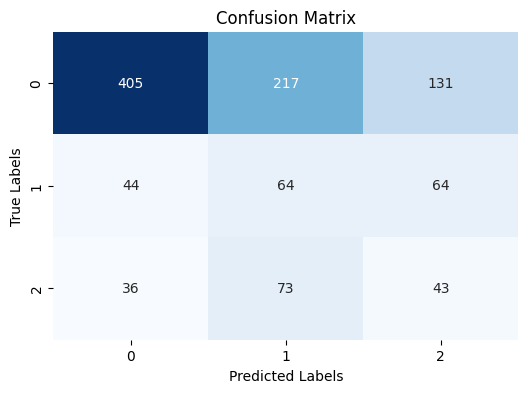


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 405/753 (53.78%)
Class 1: Correct Predictions / Total True Samples = 64/172 (37.21%)
Class 2: Correct Predictions / Total True Samples = 43/152 (28.29%)

Precision-Recall Curves:


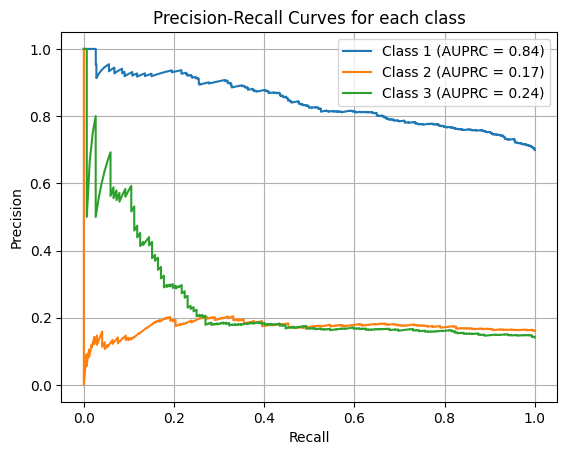


ROC Curves:


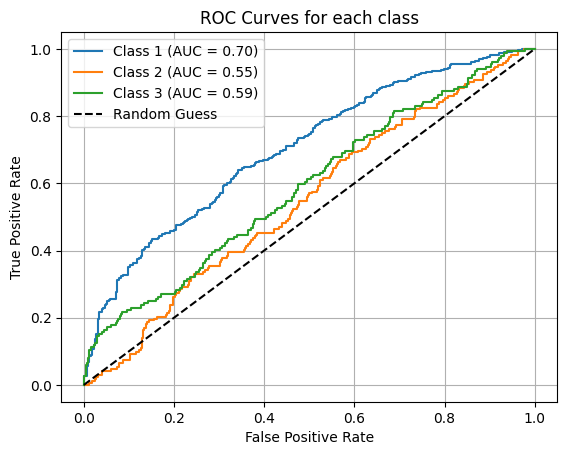


Mean F1 Score: 0.3727
Balanced Accuracy: 0.3976
Average AUPRC: 0.4182

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.54      0.65       753
           1       0.18      0.37      0.24       172
           2       0.18      0.28      0.22       152

    accuracy                           0.48      1077
   macro avg       0.40      0.40      0.37      1077
weighted avg       0.64      0.48      0.53      1077

Fold No: 4
Epoch [1/100], Loss: 1.1085, Accuracy: 0.3307
Validation Loss: 1.1301, Validation Accuracy: 0.3471
Epoch [2/100], Loss: 1.0961, Accuracy: 0.3607
Validation Loss: 1.0735, Validation Accuracy: 0.3316
Epoch [3/100], Loss: 1.0963, Accuracy: 0.3590
Validation Loss: 1.1009, Validation Accuracy: 0.3494
Epoch [4/100], Loss: 1.0880, Accuracy: 0.4120
Validation Loss: 1.0623, Validation Accuracy: 0.3665
Epoch [5/100], Loss: 1.0856, Accuracy: 0.3970
Validation Loss: 1.1325, Validation Accuracy: 0.3492
Epoch [6/100], Los

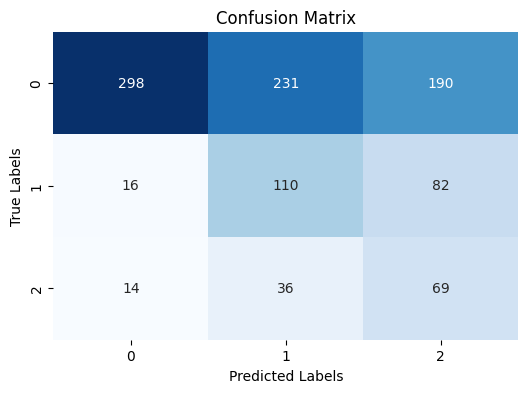


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 298/719 (41.45%)
Class 1: Correct Predictions / Total True Samples = 110/208 (52.88%)
Class 2: Correct Predictions / Total True Samples = 69/119 (57.98%)

Precision-Recall Curves:


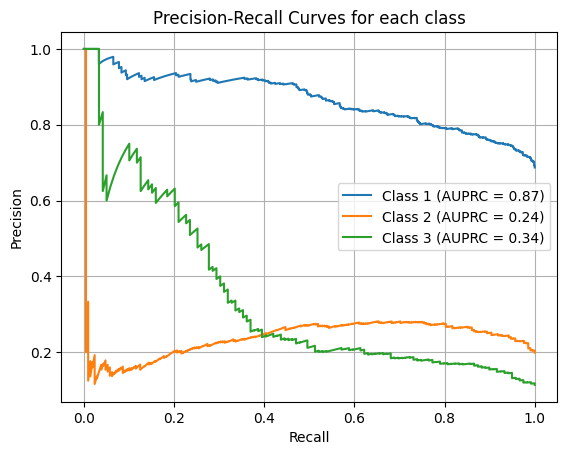


ROC Curves:


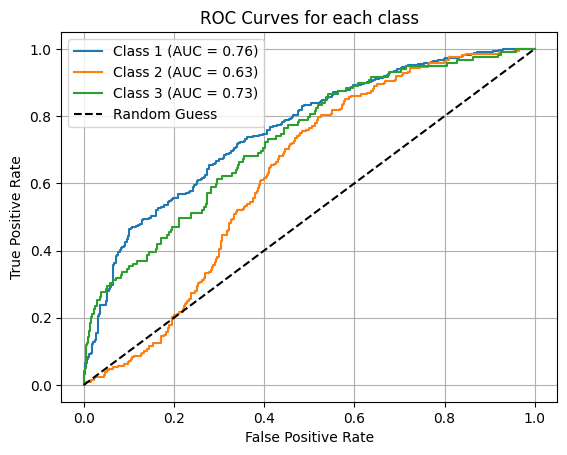


Mean F1 Score: 0.4151
Balanced Accuracy: 0.5077
Average AUPRC: 0.4812

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.41      0.57       719
           1       0.29      0.53      0.38       208
           2       0.20      0.58      0.30       119

    accuracy                           0.46      1046
   macro avg       0.47      0.51      0.42      1046
weighted avg       0.71      0.46      0.50      1046

Fold No: 5
Epoch [1/100], Loss: 1.1125, Accuracy: 0.3312
Validation Loss: 1.0597, Validation Accuracy: 0.4088
Epoch [2/100], Loss: 1.1022, Accuracy: 0.3522
Validation Loss: 1.1110, Validation Accuracy: 0.4034
Epoch [3/100], Loss: 1.0973, Accuracy: 0.3725
Validation Loss: 1.0733, Validation Accuracy: 0.4217
Epoch [4/100], Loss: 1.0929, Accuracy: 0.3928
Validation Loss: 1.0859, Validation Accuracy: 0.3880
Epoch [5/100], Loss: 1.0935, Accuracy: 0.3804
Validation Loss: 1.0689, Validation Accuracy: 0.4668
Epoch [6/100], Los

In [ ]:
import pandas as pd
import os
import datetime


import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, auc


top_params = [
    {
        'n_patches': 28,
        'embed_dim': 128,
        'learning_rate': 3.6467910524712975e-05,
        'weight_decay': 1.1407515349694686e-05,
        'batch_size': 32,
        'num_transformer_blocks': 6,
        'num_heads': 8,
        'accuracy': 0.4555
    },
    {
        'n_patches': 14,
        'embed_dim': 64,
        'learning_rate': 2.9195609817654728e-05,
        'weight_decay': 6.40075182717267e-05,
        'batch_size': 16,
        'num_transformer_blocks': 4,
        'num_heads': 4,
        'accuracy': 0.4549
    },
    {
        'n_patches': 14,
        'embed_dim': 256,
        'learning_rate': 4.658629178609918e-05,
        'weight_decay': 2.145402908576287e-05,
        'batch_size': 16,
        'num_transformer_blocks': 4,
        'num_heads': 4,
        'accuracy': 0.4516
    },
    {
        'n_patches': 14,
        'embed_dim': 256,
        'learning_rate': 2.5893793649076787e-05,
        'weight_decay': 3.284975130996957e-05,
        'batch_size': 32,
        'num_transformer_blocks': 4,
        'num_heads': 4,
        'accuracy': 0.4498
    },
    {
        'n_patches': 14,
        'embed_dim': 64,
        'learning_rate': 1.303548468658277e-05,
        'weight_decay': 2.2203605523088946e-05,
        'batch_size': 32,
        'num_transformer_blocks': 2,
        'num_heads': 4,
        'accuracy': 0.4497
    }
]

for param_id in range(3,len(top_params)):
    
    print(f"Running experiment with parameters: {top_params[param_id]}")
    print("_"*50)
    print("_"*50)
    print("_"*50)
    print("_"*50)
    print("_"*50)    
    
    # Fold indices and other configurations
    num_folds = 5
    fold_indices = np.random.permutation(np.arange(num_folds))
    val_fold_indices = np.roll(fold_indices, 1)

    test_folds_chosen = []
    val_folds_chosen = []
    fold_confusion_matrices = []  # To store confusion matrices for each fold
    fold_accuracies = []  # To store balanced accuracy for each fold
    fold_auprcs = []  # To store AUPRC for each fold

    # Model and training configurations
    num_classes = 3

    epochs = 100
    input_shape = (3, 224,224)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'


    n_patches = top_params[param_id]['n_patches']
    hidden_size = top_params[param_id]['embed_dim']
    num_transformer_blocks = top_params[param_id]['num_transformer_blocks']
    weight_decay = top_params[param_id]['weight_decay']
    num_heads = top_params[param_id]['num_heads']
    learning_rate = top_params[param_id]['learning_rate']
    factor = 1
    batch_size = top_params[param_id]['batch_size']

    def save_results_to_csv(fold_accuracies, fold_auprcs, fold_confusion_matrices, model_info, csv_path=r"F:\CODING\py\newnotebooks\results.csv"):
        """
        Save all results from the current experiment to a CSV file
        
        Parameters:
        - fold_accuracies: list of balanced accuracy scores for each fold
        - fold_auprcs: list of AUPRC scores for each fold
        - fold_confusion_matrices: list of confusion matrices for each fold
        - model_info: string with model architecture description
        - csv_path: path to the CSV file to save results
        """
        # Current time for experiment identification
        timestamp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        
        # Prepare data for the DataFrame
        data = {
            "timestamp": timestamp,
            "model_info": model_info,
            "num_classes": num_classes,
            "learning_rate": learning_rate,
            "epochs": epochs,
            "mean_balanced_accuracy": np.mean(fold_accuracies),
            "std_balanced_accuracy": np.std(fold_accuracies),
            "mean_auprc": np.mean(fold_auprcs),
            "std_auprc": np.std(fold_auprcs),
        }
        
        # Add individual fold results
        for i, (acc, auprc) in enumerate(zip(fold_accuracies, fold_auprcs)):
            data[f"fold_{i+1}_accuracy"] = acc
            data[f"fold_{i+1}_auprc"] = auprc
        
        # Add confusion matrix info
        for i, cm in enumerate(fold_confusion_matrices):
            data[f"fold_{i+1}_confusion_matrix"] = str(cm)
        
        # Create DataFrame and append to CSV
        df = pd.DataFrame([data])
        
        # Check if file exists
        file_exists = os.path.isfile(csv_path)
        
        # Save to CSV
        if file_exists:
            df.to_csv(csv_path, mode='a', header=False, index=False)
        else:
            df.to_csv(csv_path, mode='w', header=True, index=False)
        
        print(f"Results saved to {csv_path}")
        




    # Training loop for cross-validation
    for fold_idx in range(num_folds):
        print(f'Fold No: {fold_idx + 1}')
        
        # Initialize model, loss, and optimizer
        fold_model = vit(
            input_size=input_shape, 
            n_patches=n_patches, 
            hidden_size=hidden_size, 
            num_classes=num_classes,
            num_transformer_blocks=num_transformer_blocks,
            num_heads=num_heads
        ).to(device)
        fold_model.to(device)
        
        criterion = nn.CrossEntropyLoss(label_smoothing=0.3)
        optimizer = optim.Adam(fold_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        
        # Split data into train, validation, and test sets
        test_fold = fold_indices[fold_idx]
        val_fold = val_fold_indices[fold_idx]
        train_folds = [fold for fold in fold_indices if fold != test_fold and fold != val_fold]

        train_data = np.concatenate([eeg_folds[j] for j in train_folds])
        train_labels = np.concatenate([labels_folds[j] for j in train_folds])
        train_data = train_data.transpose(0, 3, 1, 2)  # Transpose to match PyTorch input format

        test_folds_chosen.append(test_fold)
        val_folds_chosen.append(val_fold)
        
        early_stopping = EarlyStopping(patience=10)
        
        # Training loop
        for epoch in range(epochs):
            balanced_train_data, balanced_train_labels = data_balancer(train_data, train_labels, factor=1)

            train_dataset = TensorDataset(
                torch.tensor(balanced_train_data, dtype=torch.float32).to(device),
                torch.tensor(balanced_train_labels, dtype=torch.long).to(device)
            )
            train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
            
            fold_model.train()
            running_loss = 0.0
            all_preds = []
            all_labels = []
            
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = fold_model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                
            epoch_loss = running_loss / len(train_loader)
            epoch_acc = balanced_accuracy_score(all_labels, all_preds)
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

            # Validation loop
            val_data = eeg_folds[val_fold].transpose(0, 3, 1, 2)
            val_labels = labels_folds[val_fold]
            val_dataset = TensorDataset(
                torch.tensor(val_data, dtype=torch.float32).to(device),
                torch.tensor(val_labels, dtype=torch.long).to(device)
            )
            val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False)

            fold_model.eval()
            val_loss = 0.0
            val_preds = []
            val_labels_list = []

            with torch.no_grad():
                for val_inputs, val_labels in val_loader:
                    val_outputs = fold_model(val_inputs)
                    loss = criterion(val_outputs, val_labels)
                    val_loss += loss.item()

                    _, val_batch_preds = torch.max(val_outputs, 1)
                    val_preds.extend(val_batch_preds.cpu().numpy())
                    val_labels_list.extend(val_labels.cpu().numpy())

            val_loss /= len(val_loader)
            val_acc = balanced_accuracy_score(val_labels_list, val_preds)
            print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')

            early_stopping(val_loss, fold_model)
            if early_stopping.early_stop:
                print("Early stopping")
                break

        # Load the best model
        early_stopping.load_best_model(fold_model)

        # Test loop
        test_data = eeg_folds[test_fold].transpose(0, 3, 1, 2)
        test_labels = labels_folds[test_fold]
        test_dataset = TensorDataset(
            torch.tensor(test_data, dtype=torch.float32).to(device),
            torch.tensor(test_labels, dtype=torch.long).to(device)
        )
        test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

        fold_model.eval()
        test_probs = []
        test_preds = []
        test_labels_list = []

        with torch.no_grad():
            for test_inputs, test_labels in test_loader:
                test_outputs = fold_model(test_inputs)
                probabilities = torch.softmax(test_outputs, dim=1)
                test_probs.extend(probabilities.cpu().numpy())
                _, preds = torch.max(probabilities, 1)
                test_preds.extend(preds.cpu().numpy())
                test_labels_list.extend(test_labels.cpu().numpy())

        # Compute metrics
        test_acc = balanced_accuracy_score(test_labels_list, test_preds)
        fold_accuracies.append(test_acc)

        cm = confusion_matrix(test_labels_list, test_preds)
        fold_confusion_matrices.append(cm)

        test_labels_binarized = label_binarize(test_labels_list, classes=np.arange(num_classes))
        test_auprcs = []
        for class_idx in range(num_classes):
            precision, recall, _ = precision_recall_curve(test_labels_binarized[:, class_idx], np.array(test_probs)[:, class_idx])
            auprc = auc(recall, precision)
            test_auprcs.append(auprc)

        mean_test_auprc = np.mean(test_auprcs)
        fold_auprcs.append(mean_test_auprc)

        print(f'Test Fold {fold_idx + 1}, Mean AUPRC: {mean_test_auprc:.4f}, Balanced Accuracy: {test_acc:.4f}')

        # Use the plot_metrics function to visualize metrics
        plot_metrics(np.array(test_labels_list), np.array(test_probs), n_classes=num_classes)

    # Final metrics across all folds
    average_auprc = np.mean(fold_auprcs)
    mean_accuracy = np.mean(fold_accuracies)
    print(f'Accuracy for each fold: {fold_accuracies}')
    print(f'AUPRC for each fold: {fold_auprcs}')
    print(f'Average AUPRC across all folds: {average_auprc}')
    print(f'Average Balanced Accuracy across all folds: {mean_accuracy}')

    model_description = f"ViT top5 params hyper{param_id} 3 classes"
    save_results_to_csv(fold_accuracies, fold_auprcs, fold_confusion_matrices, model_description,csv_path=r"D:\PYTHONIG\newwindow\NOTEBOOKS_2025\aprilmay2025\newnotebooks\results.csv")

    print("_"*50)
    print("_"*50)
    print("_"*50) 
    print("_"*50)
    print("_"*50)
    print("_"*50)
    print("_"*50)
    print("_"*50)
    print("_"*50)
    print("_"*50)    

